# EDA

## 1. Załaduj dane

In [1]:
# Standard imports
from typing import Tuple
import time

# Third party imports
from geopy.exc import  GeocoderTimedOut, GeocoderUnavailable
from geopy.geocoders import Nominatim
from haversine import haversine
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np
import pandas as pd
import plotly.graph_objects as go
import seaborn as sns
import warnings

# Local imports
from _csv_utils import data_timeplace, DataPathCleaningManager


In [2]:

data_path_manager = DataPathCleaningManager(data_timeplace)
combined_df = data_path_manager._load_cleaned_df(domain="combined")

In [3]:
import pandas as pd

def rename_columns(df: pd.DataFrame, translations: dict) -> pd.DataFrame:
    """
    Rename columns in a DataFrame with a MultiIndex according to provided translations.

    Args:
    df (pd.DataFrame): The DataFrame whose columns are to be renamed.
    translations (dict): A dictionary mapping the old column names (as tuples) to the new ones.

    Returns:
    pd.DataFrame: A new DataFrame with columns renamed.
    """
    
    # Create a new MultiIndex with the translated column names
    new_columns = []
    for col in df.columns:
        # Translate the column if it is in the translations, else keep the original
        new_col = translations.get(col, col)
        new_columns.append(new_col)

    new_index = pd.MultiIndex.from_tuples(new_columns)
    
    # Assign the new MultiIndex to the DataFrame and return it
    df.columns = new_index
    return df

# Dictionary of translations provided
columns_translation = {
    ('listing', 'link'): ('ogłoszenie', 'link'),
    ('listing', 'title'): ('ogłoszenie', 'tytuł'),
    ('listing', 'summary_description'): ('ogłoszenie', 'krótki_opis'),
    ('listing', 'remote_service'): ('ogłoszenie', 'usługa_zdalna'),
    ('pricing', 'price'): ('wycena', 'cena'),
    ('pricing', 'rent'): ('wycena', 'czynsz'),
    ('pricing', 'total_rent'): ('wycena', 'czynsz_całkowity'),
    ('pricing', 'total_rent_sqm'): ('wycena', 'czynsz_za_metr'),
    ('pricing', 'deposit'): ('wycena', 'kaucja'),
    ('pricing', 'deposit_ratio'): ('wycena', 'proporcja_kaucji'),
    ('location', 'complete_address'): ('lokalizacja', 'pełny_adres'),
    ('location', 'street'): ('lokalizacja', 'ulica'),
    ('location', 'city'): ('lokalizacja', 'miasto'),
    ('location', 'voivodeship'): ('lokalizacja', 'województwo'),
    ('size', 'square_meters'): ('wielkość', 'metry_kwadratowe'),
    ('size', 'number_of_rooms'): ('wielkość', 'liczba_pokoi'),
    ('size', 'floor'): ('wielkość', 'piętro'),
    ('size', 'attic'): ('wielkość', 'strych'),
    ('size', 'building_floors'): ('wielkość', 'liczba_pięter_budynku'),
    ('legal_and_availability', 'available_from'): ('własność_i_dostępność', 'dostępne_od'),
    ('legal_and_availability', 'completion'): ('własność_i_dostępność', 'zakończenie_budowy'),
    ('legal_and_availability', 'ownership'): ('własność_i_dostępność', 'własność'),
    ('legal_and_availability', 'rent_to_students'): ('własność_i_dostępność', 'wynajem_dla_studentów'),
    ('type_and_year', 'building_type'): ('rodzaj_i_rocznik', 'typ_budynku'),
    ('type_and_year', 'build_year'): ('rodzaj_i_rocznik', 'rok_budowy'),
    ('amenities', 'elevator'): ('udogodnienia', 'winda'),
    ('amenities', 'parking_space'): ('udogodnienia', 'miejsce_parkingowe'),
    ('equipment', 'no_information'): ('wyposażenie', 'brak_informacji'),
    ('equipment', 'stove'): ('wyposażenie', 'kuchenka'),
    ('equipment', 'fridge'): ('wyposażenie', 'lodówka'),
    ('equipment', 'furniture'): ('wyposażenie', 'meble'),
    ('equipment', 'oven'): ('wyposażenie', 'piekarnik'),
    ('equipment', 'washing_machine'): ('wyposażenie', 'pralka'),
    ('equipment', 'TV'): ('wyposażenie', 'telewizor'),
    ('equipment', 'dishwasher'): ('wyposażenie', 'zmywarka'),
    ('media_types', 'no_information'): ('media_komunikacyjne', 'brak_informacji'),
    ('media_types', 'internet'): ('media_komunikacyjne', 'internet'),
    ('media_types', 'telephone'): ('media_komunikacyjne', 'telefon'),
    ('media_types', 'cable_TV'): ('media_komunikacyjne', 'telewizja_kablowa'),
    ('heating', 'no_information'): ('ogrzewanie', 'brak_informacji'),
    ('heating', 'electric'): ('ogrzewanie', 'elektryczne'),
    ('heating', 'gas'): ('ogrzewanie', 'gazowe'),
    ('heating', 'other'): ('ogrzewanie', 'inne'),
    ('heating', 'boiler_room'): ('ogrzewanie', 'kotłownia'),
    ('heating', 'district'): ('ogrzewanie', 'miejskie'),
    ('heating', 'tile_stove'): ('ogrzewanie', 'piec_kaflowy'),
    ('security', 'no_information'): ('bezpieczeństwo', 'brak_informacji'),
    ('security', 'intercom_or_video_intercom'): ('bezpieczeństwo', 'domofon_lub_wideodomofon'),
    ('security', 'anti_burglary_doors_or_windows'): ('bezpieczeństwo', 'drzwi_lub_okna_antywłamaniowe'),
    ('security', 'monitoring_or_security'): ('bezpieczeństwo', 'monitoring_lub_ochrona'),
    ('security', 'anti_burglary_roller_blinds'): ('bezpieczeństwo', 'rolety_antywłamaniowe'),
    ('security', 'alarm_system'): ('bezpieczeństwo', 'system_alarmowy'),
    ('security', 'enclosed_area'): ('bezpieczeństwo', 'teren_ogrodzony'),
    ('windows', 'aluminum'): ('okna', 'aluminiowe'),
    ('windows', 'no_information'): ('okna', 'brak_informacji'),
    ('windows', 'wooden'): ('okna', 'drewniane'),
    ('windows', 'plastic'): ('okna', 'plastikowe'),
    ('building_material', 'concrete'): ('materiał_budowlany', 'beton'),
    ('building_material', 'aerated_concrete'): ('materiał_budowlany', 'beton_komórkowy'),
    ('building_material', 'no_information'): ('materiał_budowlany', 'brak_informacji'),
    ('building_material', 'brick'): ('materiał_budowlany', 'cegła'),
    ('building_material', 'wood'): ('materiał_budowlany', 'drewno'),
    ('building_material', 'other'): ('materiał_budowlany', 'inny'),
    ('building_material', 'lightweight_aggregate'): ('materiał_budowlany', 'keramzyt'),
    ('building_material', 'hollow_brick'): ('materiał_budowlany', 'pustak'),
    ('building_material', 'silicate'): ('materiał_budowlany', 'silikat'),
    ('building_material', 'large_panel'): ('materiał_budowlany', 'wielka_płyta'),
    ('building_material', 'reinforced_concrete'): ('materiał_budowlany', 'żelbet'),
    ('additional_information', 'no_information'): ('informacje_dodatkowe', 'brak_informacji'),
    ('additional_information', 'duplex'): ('informacje_dodatkowe', 'mieszkanie_dwupoziomowe'),
    ('additional_information', 'air_conditioning'): ('informacje_dodatkowe', 'klimatyzacja'),
    ('additional_information', 'separate_kitchen'): ('informacje_dodatkowe', 'oddzielna_kuchnia'),
    ('additional_information', 'basement'): ('informacje_dodatkowe', 'piwnica'),
    ('additional_information', 'utility_room'): ('informacje_dodatkowe', 'pomieszczenie_gospodarcze'),
    ('additional_information', 'non_smokers_only'): ('informacje_dodatkowe', 'tylko_dla_niepalących'),
}

combined_df = rename_columns(combined_df, columns_translation)

combined_df[('rodzaj_i_rocznik', 'typ_budynku')]= combined_df[('rodzaj_i_rocznik', 'typ_budynku')].map({
    'detached_house': 'dom_wolnostojący',
    'apartment_building': 'budynek_mieszkalny',
    'block_of_flats': 'blok',
    'historic_apartment_building': 'kamienica',
    'tarraced_house': 'szeregowiec',
    })

## 2. Badania eksploracyjne

### 2.1 Dane numeryczne

In [4]:
combined_df.describe().rename(index={'count': 'liczba', 'mean': 'średnia', 'std': 'odchylenie standardowe'})

wycena                               \
                                cena      czynsz czynsz_całkowity   
liczba                   1106.000000  593.000000      1106.000000   
średnia                  2180.465642  463.910624      2429.198915   
odchylenie standardowe   1429.766366  252.601285      1442.413882   
min                       500.000000    1.000000       500.000000   
25%                      1500.000000  300.000000      1687.000000   
50%                      1900.000000  500.000000      2200.000000   
75%                      2500.000000  650.000000      2800.000000   
max                     19000.000000  990.000000     19001.000000   

                                                                      \
                       czynsz_za_metr        kaucja proporcja_kaucji   
liczba                         1106.0    742.000000       742.000000   
średnia                     51.876078   3477.051213         1.457399   
odchylenie standardowe      18.852072   3698.524190         0.848110   
min                          2.708333      2.000000         0.000000   
25%                         38.693878   2000.000000         1.000000   
50%                         50.575658   3000.000000         1.295000   
75%                         63.447965   3800.000000         1.760000   
max                        138.888889  57000.000000        12.000000   

                               wielkość                         \
                       metry_kwadratowe liczba_pokoi    piętro   
liczba                           1106.0       1106.0    1083.0   
średnia                       49.740506     2.119349  2.757156   
odchylenie standardowe        26.233006     0.858414   2.57227   
min                                 8.0          1.0      -1.0   
25%                                36.0          2.0       1.0   
50%                                45.0          2.0       2.0   
75%                                56.0          3.0       4.0   
max                               413.0          6.0      11.0   

                                             rodzaj_i_rocznik  
                       liczba_pięter_budynku       rok_budowy  
liczba                                 979.0       476.000000  
średnia                              5.48621      1993.170168  
odchylenie standardowe              3.828449        33.635859  
min                                      1.0      1893.000000  
25%                                      3.0      1975.000000  
50%                                      4.0      2011.500000  
75%                                      7.0      2021.000000  
max                                     25.0      2025.000000

11 piętro to piętra 10+

**Wnioski z danych numerycznych:**

1. **Oferty**<br>
Znajdują się w promieniu `25km`<br>
od `"Mierzęcice, Będziński, Śląskie"`, w pobliżu regionalnego lotniska międzynarodowego.<br>
Całkowita liczba ofert wynosi `1106`.
2. **Średni Całkowity Czynsz**:<br>
Mediana całkowitego czynszu wynosi `2200,00 PLN`.
3. **Zakres Czynszu i Odchylenie Standardowe**:<br>
Całkowity czynsz waha się od minimum `500` do maksimum `19,001`, przy odchyleniu standardowym wynoszącym `1442,41`.<br>Równocześnie szeroki zakres i duże odchylenie standardowe wskazują na znaczną zmienność cen wynajmu.
4. **Rozmiar Nieruchomości:**<br>
Średni rozmiar nieruchomości to około `49,74` metrów kwadratowych.<br>Najmniejsza nieruchomość ma `8` metrów kwadratowych, a największa `413` metrów kwadratowych.
5. **Rok Budowy**:<br>
Nieruchomości w zestawieniu danych zostały zbudowane między `1893` a `2025`, przy medianie roku budowy `2011`.<br>Dane obejmują szeroki zakres wieku nieruchomości, od historycznych po nowoczesne konstrukcje.
6. **Informacje o na którym piętrze jest mieszkanie**:<br>Mediana pięter, na których znajdują się nieruchomości to `2` piętro, wśród nieruchomości mieszczącymi się od poziomu piwnicy (`-1`) do `10 i wyższych` pięter. Mediana dla semj liczby pięter w budynkach to około `4`, co sugeruje, że większość nieruchomości znajduje się w budynkach niskich lub średniowysokich.
7. **Koszt za Metr Kwadratowy**:<br>
Średni koszt za metr kwadratowy wynosi `51,88 PLN`, przy cenach wahających się od tak niskich jak `2,71 PLN` do tak wysokich jak `138,89 PLN` za metr kwadratowy.

### 2.2 Total rent

In [5]:
def advanced_statistical_analysis(df: pd.DataFrame = combined_df):
    price_data = df['wycena']['czynsz_całkowity']

    # Central Tendency Measures
    mean_price = price_data.mean()
    median_price = price_data.median()
    mode_price = price_data.mode()[0]

    # Variability Measures
    std_dev_price = price_data.std()
    variance_price = price_data.var()
    range_price = price_data.max() - price_data.min()
    iqr_price = np.percentile(price_data, 75) - np.percentile(price_data, 25)

    # Skewness and Kurtosis
    skewness_price = price_data.skew()
    kurtosis_price = price_data.kurtosis()

    # Quantile Analysis
    quantiles_price = price_data.quantile([0.25, 0.5, 0.75, 0.9, 0.95, 0.99])

    # Outlier Detection: Using the 1.5*IQR rule
    lower_bound = np.percentile(price_data, 25) - 1.5 * iqr_price
    upper_bound = np.percentile(price_data, 75) + 1.5 * iqr_price
    outliers_upper = price_data[(price_data >= upper_bound)].count()
    outliers_lower = price_data[(price_data <= lower_bound)].count()
    outlier_total = outliers_upper + outliers_lower

    advanced_statistics = {
        "Średnia": mean_price.round(2),
        "Mediana": median_price,
        "Odchylenie standardowe": std_dev_price.round(2),
        "Dominanta": mode_price,
        "Wariancja": variance_price.round(2),
        "Zakres": range_price,
        "Rozstęp międzykwartylowy (IQR)": iqr_price,
        "Skośność": skewness_price.round(2),
        "Kurtoza": kurtosis_price.round(2),
        "Kwantyle": quantiles_price,
        "Dolna granica wykrywania wartości odstających": lower_bound,
        "Górna granica wykrywania wartości odstających": upper_bound,
        "Liczba wartości poniżej dolnej granicy": outliers_upper,
        "Liczba wartości powyżej górnej granicy": outliers_lower,
        "Liczba wartości odstających": outlier_total,
        "Całkowita liczba ofert": price_data.count(),
        "Stosunek liczby wartości odstających do całkowitej liczby ofert": str((outlier_total / price_data.count()).round(2) * 100)+ "%",
    }

    print("Cena łączna, zaawansowane statystyki:")
    return advanced_statistics

advanced_statistical_analysis(combined_df)

Cena łączna, zaawansowane statystyki:


{'Średnia': 2429.2,
 'Mediana': 2200.0,
 'Odchylenie standardowe': 1442.41,
 'Dominanta': 1500.0,
 'Wariancja': 2080557.81,
 'Zakres': 18501.0,
 'Rozstęp międzykwartylowy (IQR)': 1113.0,
 'Skośność': 4.89,
 'Kurtoza': 41.71,
 'Kwantyle': 0.25    1687.0
 0.50    2200.0
 0.75    2800.0
 0.90    3557.5
 0.95    4569.5
 0.99    7270.0
 Name: czynsz_całkowity, dtype: float64,
 'Dolna granica wykrywania wartości odstających': 17.5,
 'Górna granica wykrywania wartości odstających': 4469.5,
 'Liczba wartości poniżej dolnej granicy': 67,
 'Liczba wartości powyżej górnej granicy': 0,
 'Liczba wartości odstających': 67,
 'Całkowita liczba ofert': 1106,
 'Stosunek liczby wartości odstających do całkowitej liczby ofert': '6.0%'}

**Wnioski z analizy cen wynajmu:**

1. **Tendencja cen wynajmu**:<br>
Wiele czynszów jest bardziej przystępnych cenowo, podczas gdy tylko kilka jest naprawdę drogich.

1. **Wyjątkowe ceny wynajmu**:<br>
Około `6%` cen wynajmu jest znacznie wyższych lub niższych od typowych.
Te kilka nietypowych czynszów może sprawić, że średnia będzie wyglądać na wyższą niż to, co widzi większość ludzi.

1. **Zróżnicowanie cen wynajmu**:<br>
Analizując dane dotyczące wynajmu, spektrum cen jest bardzo szerokie.<br>
Większość wynajmów `(75%)` jest w przeciętnych cenach.<br>
Jednak patrząc na ceny wyższe od przeciętnych ceny wynajmu znacząco rosną.<br>
Górne `5%` nieruchomości mają czynsze znacznie wyższe od średniej,<br>
a górne `1%` znajdują się w jeszcze bardziej ekskluzywnym przedziale cenowym.<br>


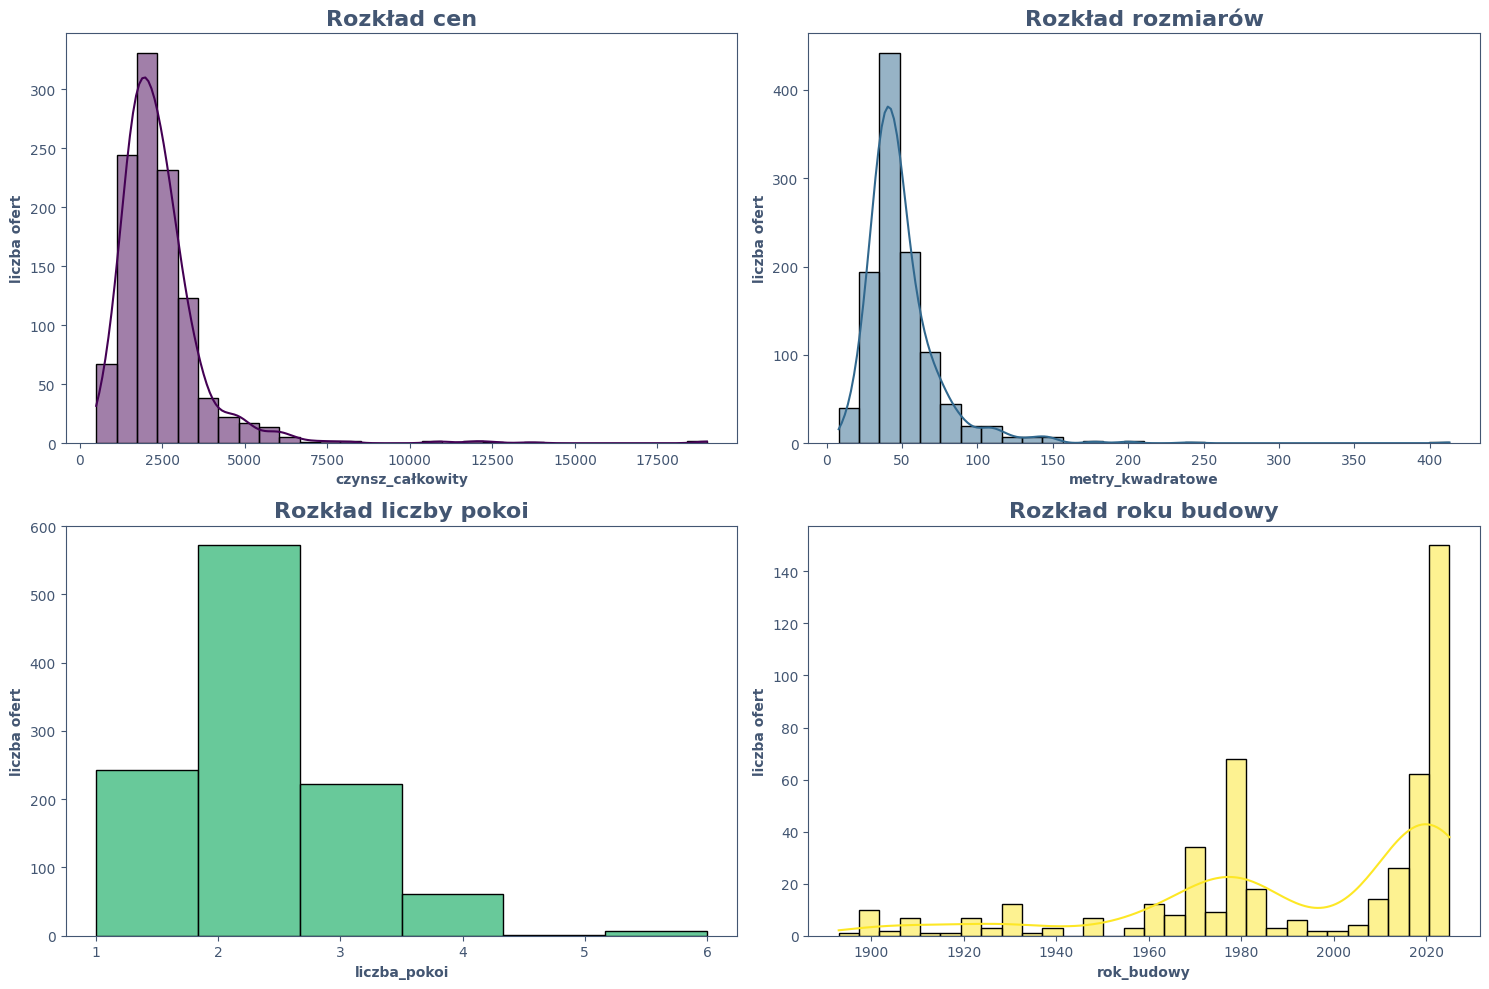

In [6]:
aesthetics_plots = {
	'title_size': 16,
    'y_and_x_label_size': 12,
	'fontweight': 'bold',
	'label_color': "#435672",
    "palette": "viridis",
    "figsize": {
        "multiplot": (15, 10),  # (width, height) in inches
        "singleplot": (8, 6),
        },
    }


def set_plot_aesthetics(
        ax: plt.Axes, 
        title: str, 
        title_fontsize: int = aesthetics_plots['title_size'], 
        color: str =aesthetics_plots['label_color'], 
        fontweight: str =aesthetics_plots['fontweight']
    ):


    ax.set_title(title, fontsize=title_fontsize, color=color, fontweight=fontweight)
    ax.set_xlabel(ax.get_xlabel(), fontweight=fontweight)
    ax.set_ylabel(ax.get_ylabel(), fontweight=fontweight)
    ax.tick_params(colors=color, which='both')  # For both major and minor ticks
    ax.yaxis.label.set_color(color)  # Y-axis label color
    ax.xaxis.label.set_color(color)  # X-axis label color
    for spine in ax.spines.values():  # Spine color
        spine.set_edgecolor(color)

def plot_distribution(combined_df: pd.DataFrame):
    fig, axes = plt.subplots(nrows=2, ncols=2, figsize=aesthetics_plots['figsize']['multiplot'])

    cmap = plt.get_cmap('viridis')
    colors = cmap(np.linspace(0, 1, 4))

    titles = ["Rozkład cen", "Rozkład rozmiarów", "Rozkład liczby pokoi", "Rozkład roku budowy"]
    data_columns = ['wycena.czynsz_całkowity', 'wielkość.metry_kwadratowe', 'wielkość.liczba_pokoi', 'rodzaj_i_rocznik.rok_budowy']
    kde_settings = [True, True, False, True]
    bins = [30, 30, 6, 30]

    for ax, title, color, data_column, kde_setting, bin in zip(axes.flat, titles, colors, data_columns, kde_settings, bins):
        sns.histplot(combined_df[data_column.split('.')[0]][data_column.split('.')[1]].astype('float'), ax=ax, kde=kde_setting, bins=bin, color=color)
        ax.set_ylabel("liczba ofert")
        set_plot_aesthetics(ax, title)

    plt.tight_layout()
    plt.show()

plot_distribution(combined_df)

**Wnioski z danych liczbowych:**

1. **Ceny wynajmu**:<br>
Większość czynszów jest niska, z najczęszczą kwotą około `2500`. Nie ma wielu drogich mieszkań do wynajęcia.

2. **Wielkość mieszkań**:<br>
Częstsze są mniejsze mieszkania (około `50 m2`) niż większe. Dużych apartamentów jest niewiele.
Większość dostępnych mieszkań składa się z dwóch pomieszczeń dodatkowych poza kuchnią, łazienką oraz ewentualnym korytarzem.

1. **Wiek Budynków**:<br>
Wiele budynków zostało wzniesionych około roku `1980`, a ostatnio obserwujemy wzrost nowych budowli od około `2020`.<br>
Ogólnie widać brak starych budynków na rynku wynajmu.

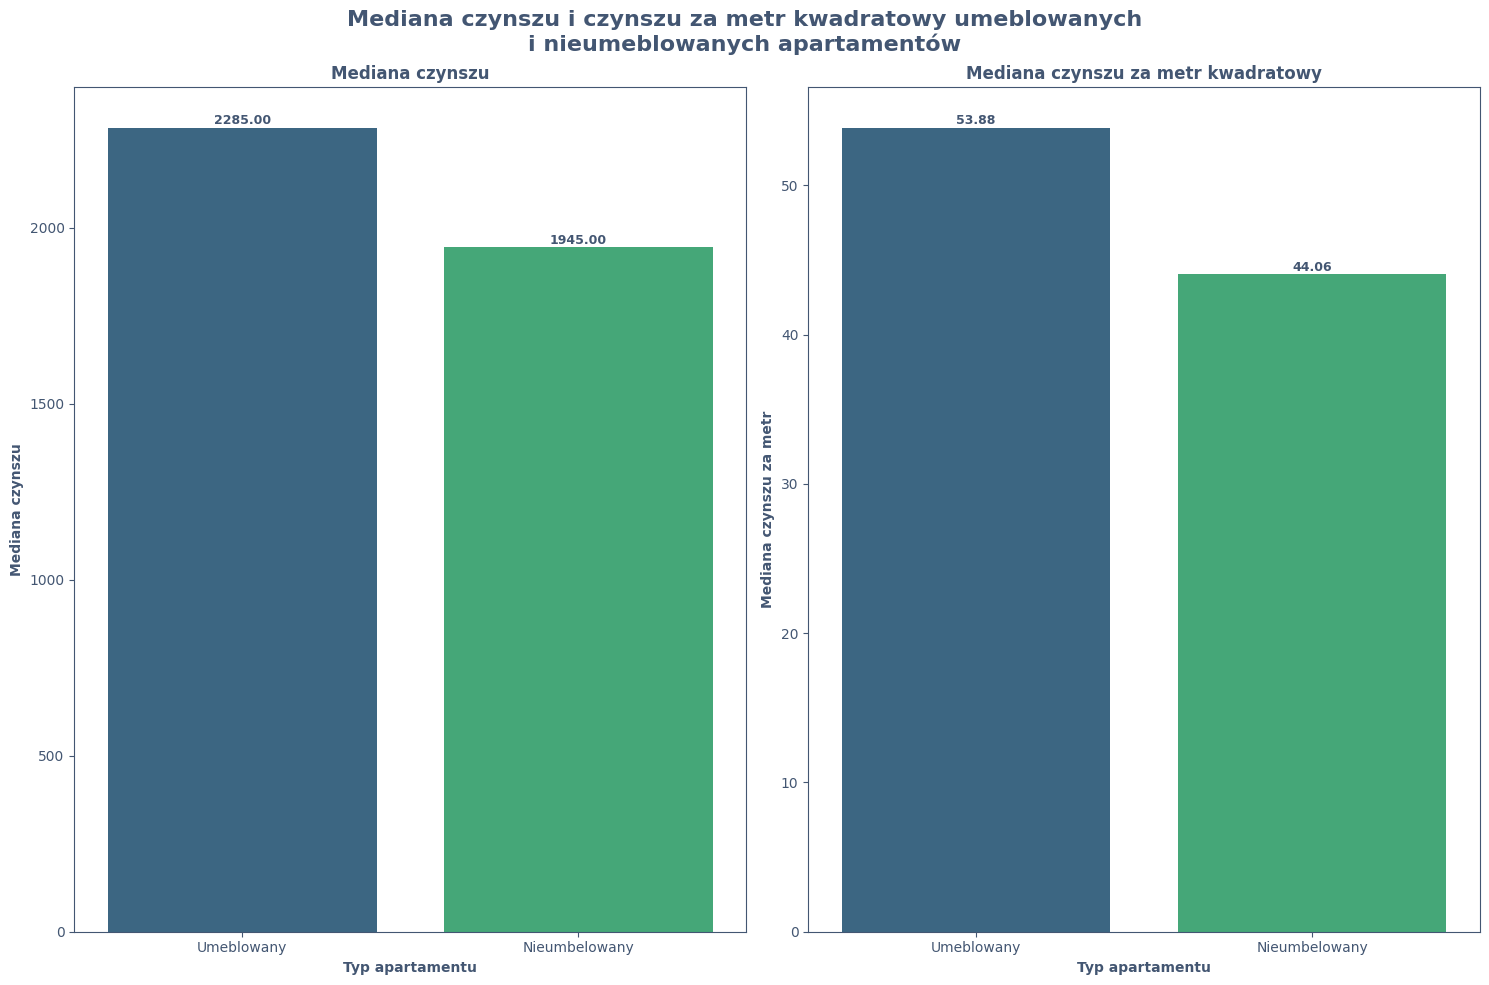

Różnice median:
Umeblowane vs nieumeblowane: 340.0 PLN
Umeblowane vs nieumeblowane na metr kwadratowy: 10.0 PLN


In [7]:
def set_plot_aesthetics(ax, title=None, xlabel=None, ylabel=None, title_color="#435672", tick_color="#435672", fontweight='bold'):
    if title:
        ax.set_title(title, color=title_color, fontweight=fontweight)
    if xlabel:
        ax.set_xlabel(xlabel, fontweight=fontweight)
    if ylabel:
        ax.set_ylabel(ylabel, fontweight=fontweight)
    ax.tick_params(colors=tick_color, which='both')  # For both major and minor ticks
    ax.yaxis.label.set_color(tick_color)  # Y-axis label color
    ax.xaxis.label.set_color(tick_color)  # X-axis label color
    for spine in ax.spines.values():  # Spine color
        spine.set_edgecolor(tick_color)

def plot_distribution(combined_df: pd.DataFrame):

    # No information about furniture delete
    # refactor

    # Calculate medians
    median_furnished = combined_df[combined_df['wyposażenie']['meble']]['wycena']['czynsz_całkowity'].median()
    median_unfurnished = combined_df[~combined_df['wyposażenie']['meble']]['wycena']['czynsz_całkowity'].median()
    
    median_furnished_sqm = (combined_df[combined_df['wyposażenie']['meble']]['wycena']['czynsz_za_metr']).median()
    median_unfurnished_sqm = (combined_df[~combined_df['wyposażenie']['meble']]['wycena']['czynsz_za_metr']).median()

    # Prepare data for plotting
    median_data_furnishing = pd.DataFrame({
        'Umeblowanie': ['Umeblowany', 'Nieumbelowany'],
        'Mediana czynszu': [median_furnished, median_unfurnished]
    })

    median_data_square_meter = pd.DataFrame({
        'Umeblowanie': ['Umeblowany', 'Nieumbelowany'],
        'Mediana czynszu za metr kwadratowy': [median_furnished_sqm, median_unfurnished_sqm]
    })

    title = 'Mediana czynszu i czynszu za metr kwadratowy umeblowanych\ni nieumeblowanych apartamentów'

    # Create a figure with two subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=aesthetics_plots['figsize']['multiplot'])

    # Plotting Median Rent
    sns.barplot(x='Umeblowanie', y='Mediana czynszu', data=median_data_furnishing, ax=ax1, palette='viridis')

    # Plotting Median Czynsz per Square Meter
    sns.barplot(x='Umeblowanie', y='Mediana czynszu za metr kwadratowy', data=median_data_square_meter, ax=ax2, palette='viridis')

    for ax in [ax1, ax2]:
        for p in ax.patches:
            ax.annotate(f'{p.get_height():.2f}', (p.get_x() + p.get_width() / 2., p.get_height()), 
                        ha='center', va='center', fontsize=9, color=aesthetics_plots["label_color"], fontweight='bold',
                        xytext=(0, 5),
                        textcoords='offset points')
            
    # Apply aesthetics to each subplot
    set_plot_aesthetics(ax1, title='Mediana czynszu', xlabel='Typ apartamentu', ylabel='Mediana czynszu')
    set_plot_aesthetics(ax2, title='Mediana czynszu za metr kwadratowy', xlabel='Typ apartamentu', ylabel='Mediana czynszu za metr')

    # Set the main title for the figure
    fig.suptitle(title, color="#435672", fontsize=aesthetics_plots['title_size'], fontweight='bold')


    plt.tight_layout()
    plt.show()

    print(f"Różnice median:")
    print(f"Umeblowane vs nieumeblowane: {abs(median_furnished - median_unfurnished)} PLN")
    print(f"Umeblowane vs nieumeblowane na metr kwadratowy: {(abs(median_furnished_sqm - median_unfurnished_sqm)).round()} PLN")

plot_distribution(combined_df)

**Wnioski dotyczące cen mieszkań umeblowanych vs nieumeblowanych:**

1. **Wyższy czynsz za mieszkania umeblowane**:<br>
Mieszkania umeblowane mają wyższy czynsz w porównaniu do nieumeblowanych o `340 PLN`.<br>
Sugeruje to, że najemcy płacą więcej za dodatkową wygodę.

1. **Umeblowanie nieznacznie podnosi cenę**:<br>
Różnica w cenie wynajmu za metr kwadratowy pomiędzy mieszkaniami umeblowanymi a nieumeblowanymi jest marginalna (`10 PLN`), co może oznaczać, że za umeblowanie płaci się niewielką dopłatę bez względu na rozmiar mieszkania.

In [8]:
def show_categorical_data_percentage_distribution(
        df: pd.DataFrame, 
        categorical_column: Tuple[str, str], 
        distribution_column: Tuple[str, str], 
        title: str,
        x_ticks_number: int = 10,
        y_ticks_number: int = 8,
        x_ticks_rotation: bool = True,
        y_ticks_rotation: bool = True,
    ):
    
    # Create a subset DataFrame with only the required columns
    plot_data = df[[categorical_column, distribution_column]].dropna()

    # Set up the matplotlib figure
    plt.figure(figsize=(14, 7))

    # Get unique building types from the categorical column
    building_types = plot_data[categorical_column].unique()

    # Generate a list of colors, one for each building type
    my_palette = ['#bfed2d'] + ['#00c37f'] + ["#007e90"] + ['#51006f'] + ["#FF9F66"]

    ax = plt.gca()  # Get the current Axes instance on the current figure matching the given keyword args, or create one.

    # Plot each building type's histogram
    for building_type, color in zip(building_types, my_palette):
        # Select the rows where the building type matches and is not null
        subset = plot_data[plot_data[categorical_column] == building_type]
        sns.histplot(subset[distribution_column], kde=False, color=color, label=building_type, ax=ax)

    
    # Add some formatting and titles
    x_axis_title = distribution_column[1].replace('_', ' ')

    plt.title(title, color=aesthetics_plots['label_color'], fontsize=aesthetics_plots['title_size'], weight=aesthetics_plots['fontweight'])
    plt.xlabel(x_axis_title, color=aesthetics_plots['label_color'], fontsize=aesthetics_plots['y_and_x_label_size'], weight=aesthetics_plots['fontweight'])
    plt.ylabel('częstotliwość', color=aesthetics_plots['label_color'], fontsize=aesthetics_plots['y_and_x_label_size'], weight=aesthetics_plots['fontweight'])

    legend = plt.legend(title=x_axis_title)
    plt.setp(legend.get_title(), fontsize='large', color=aesthetics_plots['label_color'], weight='bold')
    plt.setp(legend.get_texts(), color=aesthetics_plots['label_color'])

    # Customize x-axis ticks
    ax.xaxis.set_major_locator(ticker.MaxNLocator(nbins=x_ticks_number))
    ax.yaxis.set_major_locator(ticker.MaxNLocator(nbins=y_ticks_number))

    if x_ticks_rotation:
        ax.xaxis.set_major_locator(ticker.FixedLocator(ax.get_xticks()))
        ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
        
    if y_ticks_rotation:
        ax.yaxis.set_major_locator(ticker.FixedLocator(ax.get_yticks()))
        ax.set_yticklabels(ax.get_yticklabels(), rotation=45)

    plt.xticks(color=aesthetics_plots['label_color'])
    plt.yticks(color=aesthetics_plots['label_color'])
    
    sns.despine(right=True, top=True)

    # Add annotations for each bar
    for p in ax.patches:
        # Calculate the percentage of the total
        percentage = (p.get_height() / len(df)) * 100
        # Place the annotation above the bar
        if percentage > 0:
            ax.annotate(f"{percentage:.1f}%", (p.get_x() + p.get_width() / 2., p.get_height()),
                        ha='center', va='bottom', fontsize=10, color=aesthetics_plots['label_color'], xytext=(0, 8),
                        textcoords='offset points')

    # Show the plot
    plt.show()

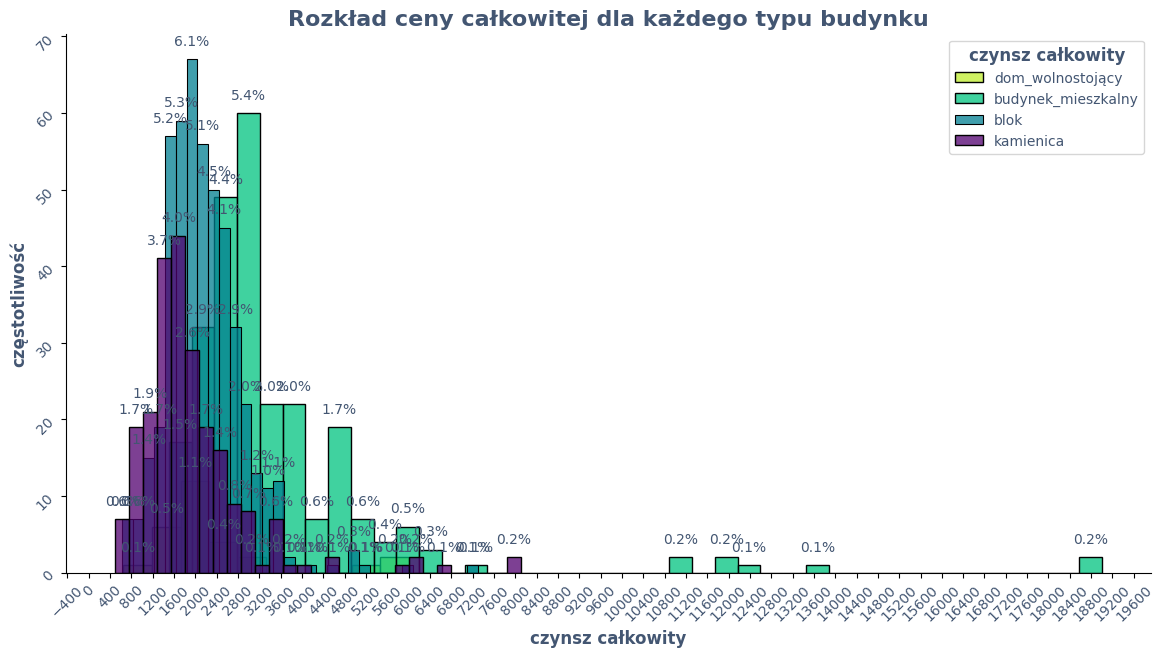

In [9]:
show_categorical_data_percentage_distribution(
    combined_df,  
    ('rodzaj_i_rocznik', 'typ_budynku'),
    ('wycena', 'czynsz_całkowity'),
    'Rozkład ceny całkowitej dla każdego typu budynku',
    x_ticks_number= 60,
    x_ticks_rotation= True
    )

**Wnioski z rozkładu cen każdego typu budynku**:

1. **Budynki Mieszkalne**:<br>
Ceny mieszkań w budynkach mieszkalnych wahają się od `400` do `8000` PLN, z większością ofert skupionych w przedziale od `400` do `3.200` PLN. Większość ofert jest dostępna w przystępnej cenie, co jest korzystne dla osób z ograniczonym budżetem.

1. **Bloki Mieszkalne**:<br>
Ceny w blokach mieszkalnych wykazują różnorodność, z cenami mieszkań rozciągającymi się od `800` do `3.600` PLN, przy okazjonalnych ofertach w wyższej cenie (`4.800` do `5.000` PLN).

1. **Kamienice**:<br>
W historycznych kamienicach ceny mieszkań obejmują szeroki zakres – od `400` do `3.600` PLN, z kilkoma apartamentami w wyższym segmencie cenowym (`4.000`, `5.600`, `6.000`, `8.000` PLN).

c:\Users\karol\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\distributions.py:499: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  pd.Index(edges, name="edges"),
c:\Users\karol\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\distributions.py:500: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  pd.Index(widths, name="widths"),
c:\Users\karol\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\distributions.py:499: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  pd.Index(edges, name="edges"),
c:\Users\karol\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\distributions.py:500: FutureWarning: In a future version, t

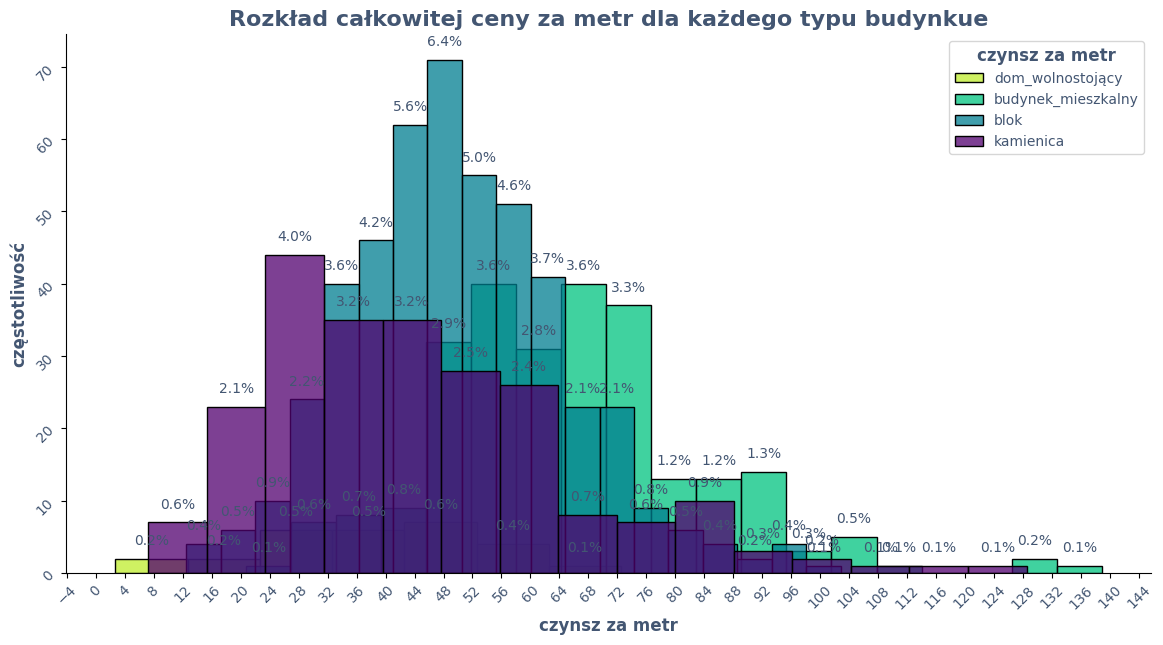

In [10]:
show_categorical_data_percentage_distribution(
    combined_df,  
    ('rodzaj_i_rocznik', 'typ_budynku'),
    ('wycena', 'czynsz_za_metr'),
    'Rozkład całkowitej ceny za metr dla każdego typu budynkue',
    x_ticks_number= 40,
    x_ticks_rotation= True
    )

**Wnioski z cen za metr kwadratowy na podstawie różnych typów budynków**:

1. **Cena za Metr w Budynkach Mieszkalnych**:<br>
W budynkach mieszkalnych cena za metr kwadratowy zazwyczaj wynosi około `50` PLN. Jest to najczęściej spotykany przedział cenowy w tej kategorii.

1. **Cena za Metr w Historycznych Kamienicach**:<br>
W historycznych kamienicach ceny za metr kwadratowy są bardziej zróżnicowane. Większość ofert koncentruje się w niższych i wyższych zakresach cenowych, z wyraźnym skupieniem wokół `24` PLN za m².

1. **Cena za Metr w Domach Szeregowych**:<br>
Chociaż domy szeregowe są rzadziej spotykane, to oferują one większą przestrzeń za niższą cenę za metr kwadratowy, z przedziałem cenowym przeważnie od `4` do `24` PLN za m². To wskazuje na korzystniejsze warunki dla szukających przestronniejszych mieszkań za umiarkowaną cenę.

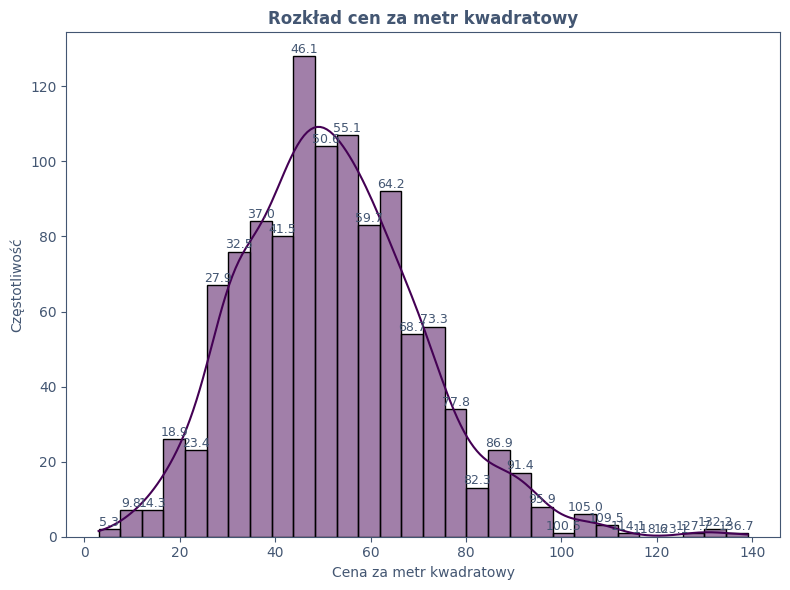

In [11]:
def plot_distribution(combined_df: pd.DataFrame):

    # Calculation with handling of potential division by zero or NaN values
    plot_data = combined_df['wycena']['czynsz_za_metr']
    plot_data = plot_data.dropna().round().astype('float')

    cmap = plt.get_cmap('viridis')
    colors = cmap(np.linspace(0, 1, 4))
    color = colors[0]
    title = 'Rozkład cen za metr kwadratowy'

    fig, ax = plt.subplots(figsize=aesthetics_plots['figsize']['singleplot'])
    hist = sns.histplot(plot_data, kde=True, bins=30, color=color, ax=ax)
    ax.set_xlabel('Cena za metr kwadratowy')
    ax.set_ylabel('Częstotliwość')

    for p in hist.patches:
        bin_center = p.get_x() + p.get_width() / 2
        ax.annotate(f'{bin_center:.1f}', (bin_center, p.get_height()), 
                    ha='center', va='center', fontsize=9, color=aesthetics_plots["label_color"], xytext=(0, 5),
                    textcoords='offset points')
        
    set_plot_aesthetics(ax, title)

    plt.tight_layout()
    plt.show()

plot_distribution(combined_df)

**Wnioski cena za metr kwadratowy**:

1. **Powszechne ceny wynajmu**:<br>
Większość mieszkań kosztuje około `50` PLN za każdy metr kwadratowy.<br>
Rzadziej spotyka się mieszkania, za które pobiera się wyższą opłatę za metr kwadratowy.

1. **Niewiele mieszkań z wyższą stawką**:<br>
Diagram wskazuje, że choć istnieją pojedyncze mieszkania z wyjątkowo wysoką ceną za metr kwadratowy,
są one stosunkowo rzadkie. Większość ofert utrzymuje się w standardowym zakresie cen.

In [12]:
CategoryResults = list[Tuple[str, str, float]]

def get_correlations(data: pd.DataFrame):
    
    def get_correlation_category(bottom_threshold: float, upper_threshold: float = 1.0):

        category_results: CategoryResults = []
        num_columns = len(columns)

        for i in range(num_columns):
            for j in range(i+1, num_columns):

                corr_value = correlations.iloc[i, j]
                col_left = columns[i]
                col_right = columns[j]

                category_results = add_correlation_value(
                        bottom_threshold, 
                        upper_threshold, 
                        category_results, 
                        corr_value, 
                        col_left, 
                        col_right
                    )
        
        sorted_results = sorted(category_results, key=lambda x: x[2], reverse=True)
        return sorted_results

    def add_correlation_value(
                bottom_threshold: float, 
                upper_threshold: float, 
                category_results: CategoryResults, 
                corr_value: float, 
                col_left: str, 
                col_right: str
            ):

        if upper_threshold == 1.0:
            if bottom_threshold <= abs(corr_value):
                category_results.append((col_left, col_right, corr_value))
        else:
            if bottom_threshold <= abs(corr_value) < upper_threshold:
                category_results.append((col_left, col_right, corr_value))

        return category_results
    
    correlations = data.corr()
    columns = correlations.columns
    correlations_results = {}
    
    correlations_results['Silna korelacja'] = get_correlation_category(bottom_threshold = 0.7)
    correlations_results['Przeciętna korelacja'] = get_correlation_category(bottom_threshold = 0.3, upper_threshold = 0.7)
    correlations_results['Słaba korelacja'] = get_correlation_category(bottom_threshold = 0.1, upper_threshold = 0.3)

    return correlations_results

def print_results(correlations_results: dict[str, CategoryResults]):

    for level, results in correlations_results.items():
        print(f"\n{level}:")
        for col_left, col_right, corr_value in results:
            print(f"{col_left} - {col_right}: {round(corr_value, 2)}")
        print("\r")

def print_correlations(data: pd.DataFrame):
    
    correlations_results = get_correlations(data)
    
    print_results(correlations_results)

def get_top_extreme_results(correlations_results: dict[str, CategoryResults], column_of_interest: str, num_positive_negative: int):

    top_positive = []

    positive_count = 0

    for _, results in correlations_results.items():

        for col_left, col_right, corr_value in results:

            if corr_value > 0:

                correlation_cols = [col_left, col_right]

                if column_of_interest in correlation_cols:

                    if positive_count == num_positive_negative:
                        break

                    corr_item = (col_left, col_right, corr_value)

                    top_positive.append(corr_item)

                    positive_count += 1

        if positive_count == num_positive_negative:
            break

    top_negative = []

    negative_count = 0

    reversed_dict = dict(reversed(correlations_results.items()))

    for _, results in reversed_dict.items():

        for col_left, col_right, corr_value in results:

            if corr_value < 0:

                correlation_cols = [col_left, col_right]

                if column_of_interest in correlation_cols:

                    if negative_count == num_positive_negative:
                        break

                    corr_item = (col_left, col_right, corr_value)

                    top_negative.insert(0, corr_item)

                    negative_count += 1

        if negative_count == num_positive_negative:
            break

    top_positive.extend(top_negative)

    return top_positive

In [13]:

def show_extreme_correlations(data: pd.DataFrame, column_of_interest: Tuple[str, str], num_results: int = 5, title: str = "Add title"):

    columns_to_drop = [('wycena', 'cena'), ('wycena', 'czynsz')]
    data = data.drop(columns=columns_to_drop)
    correlations_results = get_correlations(data)
    extreme_correlations = get_top_extreme_results(correlations_results, column_of_interest, num_results)

    unique_elements = list(
        set([item[0] for item in extreme_correlations] + [item[1] for item in extreme_correlations])
    )
    correlation_values = np.zeros((len(unique_elements), len(unique_elements)))

    element_index_mapping = {
        element: index for index, element in enumerate(unique_elements)
    }

    for item in extreme_correlations:
        col1, col2, corr_value = item
        row_index = element_index_mapping[col2]
        col_index = element_index_mapping[col1]
        correlation_values[row_index, col_index] = corr_value

    df = pd.DataFrame(correlation_values, index=unique_elements, columns=unique_elements)
    df_column_of_interest = df[[column_of_interest]]
    df_no_empty_value = df_column_of_interest.drop(index=column_of_interest)
    df_no_0 = df_no_empty_value.drop(df_no_empty_value[df_no_empty_value.eq(0).all(axis=1)].index)
    df_plot = df_no_0.sort_values(by=column_of_interest, ascending=False)

    with plt.style.context('seaborn'):
        plt.figure(figsize=aesthetics_plots['figsize']['singleplot'])
        heatmap = sns.heatmap(df_plot, cmap='coolwarm', vmin = -1.0, vmax = 1.0, annot=True, fmt=".2f", annot_kws={'color': "white", 'fontweight': "bold"}, cbar=True, cbar_kws={"label": "Correlation"})
        # set color palette proportional to values 1.0 is always max 0.0 always least color value
        heatmap.set_xlabel("")
        heatmap.set_yticklabels(heatmap.get_yticklabels(), rotation=0, color=aesthetics_plots['label_color'])
        heatmap.set_xticklabels([])
        
        # Add the following lines
        cbar = heatmap.collections[0].colorbar
        cbar.set_ticks([heatmap.collections[0].get_array().min(), heatmap.collections[0].get_array().max()])
        cbar.set_ticks([-1.0, 0, 1.0])  # Set the tick locations
        cbar.set_ticklabels(['-1.0', '0.0', '1.0'])  # Set the tick labelss
        cbar.ax.yaxis.set_ticklabels(cbar.ax.yaxis.get_ticklabels(), color=aesthetics_plots['label_color'])  # Set the tick label color
        cbar.set_label("Correlation", color=aesthetics_plots['label_color'])
        
        plt.title(f'Correlation: {title}\n', color=aesthetics_plots['label_color'], fontsize = aesthetics_plots['title_size'], weight=aesthetics_plots['fontweight'])
        plt.show()


C:\Users\karol\AppData\Local\Temp\ipykernel_26212\1916956216.py:47: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlations = data.corr()


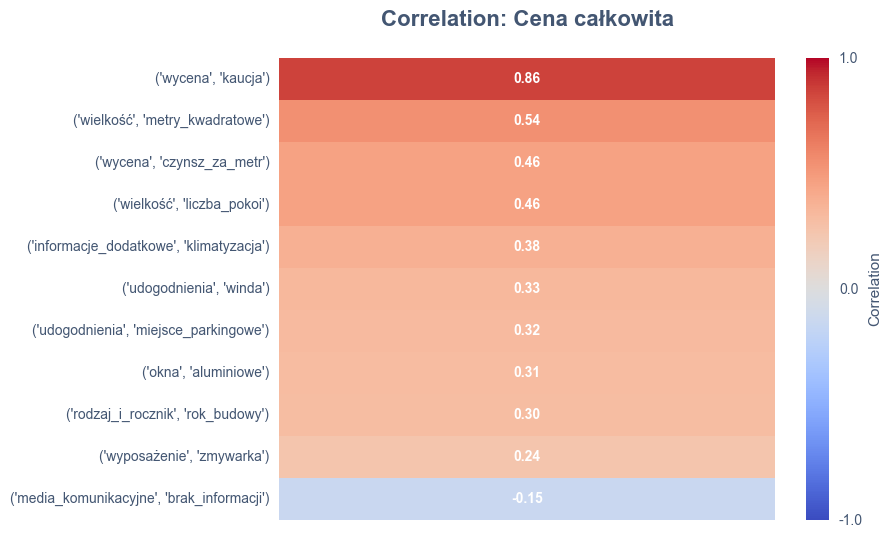

In [14]:
show_extreme_correlations(combined_df, ('wycena', 'czynsz_całkowity'), num_results = 10, title="Cena całkowita")

**Wnioski z korelacji ceny całkowitej**:

1. **Związek między kaucją a ceną wynajmu**:<br>
Istnieje silna dodatnia zależność między wysokością kaucji a całkowitą ceną, wskazując na korelację wynoszącą `0.86`.<br>
Sugeruje to, że droższe oferty wynajmu zazwyczaj wymagają wyższej kaucji.

1. **Wielkość ma znaczenie**:<br>
Rozmiar mieszkania, mierzony w metrach kwadratowych, ma istotną dodatnią korelację (`0.54`) z całkowitą ceną,<br>
Liczba pokoi również wykazuje dodatnią korelację (`0.46`) z ceną, choć nie jest ona tak silna jak w przypadku wielkości w metrach kwadratowych,<br>co wskazuje, że ogólny rozmiar może mieć większy wpływ na cenę niż sama liczba pokoi.

1. **Brak Informacji, a inne cechy**:<br>
Mieszkania z dodatkami, takimi jak klimatyzacja, mają tendencję do wyższych cen, co potwierdza korelacja `0.38`.<br>
Z kolei oferty z mniejszą ilością informacji lub ich brakiem często są nieco tańsze – tu korelacja wynosi (`-0.15`). Może to oznaczać, że mniej kosztowne oferty często są mniej szczegółowo opisane.

Inne korelacje:

In [15]:
print_correlations(combined_df)

C:\Users\karol\AppData\Local\Temp\ipykernel_26212\1916956216.py:47: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlations = data.corr()



Silna korelacja:
('wycena', 'cena') - ('wycena', 'czynsz_całkowity'): 0.98
('wyposażenie', 'kuchenka') - ('wyposażenie', 'lodówka'): 0.89
('wyposażenie', 'lodówka') - ('wyposażenie', 'pralka'): 0.89
('wycena', 'cena') - ('wycena', 'kaucja'): 0.88
('wycena', 'czynsz_całkowity') - ('wycena', 'kaucja'): 0.86
('wyposażenie', 'kuchenka') - ('wyposażenie', 'pralka'): 0.85
('wyposażenie', 'kuchenka') - ('wyposażenie', 'piekarnik'): 0.84
('wyposażenie', 'lodówka') - ('wyposażenie', 'piekarnik'): 0.78
('wyposażenie', 'piekarnik') - ('wyposażenie', 'pralka'): 0.76
('media_komunikacyjne', 'internet') - ('media_komunikacyjne', 'telewizja_kablowa'): 0.73
('wielkość', 'piętro') - ('wielkość', 'liczba_pięter_budynku'): 0.71
('media_komunikacyjne', 'brak_informacji') - ('media_komunikacyjne', 'telewizja_kablowa'): -0.79
('bezpieczeństwo', 'brak_informacji') - ('bezpieczeństwo', 'domofon_lub_wideodomofon'): -0.85
('wyposażenie', 'brak_informacji') - ('wyposażenie', 'meble'): -0.87
('okna', 'brak_infor

**Wnioski z innych korelacji:**

1. **Cena najmu jako główny koszt**:<br>
Prawie doskonała korelacja (`0.98`) między `'ceną najmu'` a `'całkowitym czynszem'` wskazuje, że cena najmu konsekwentnie przyczynia się do całkowitego kosztu wynajmu, a w mniejszym stopniu koszty dodatkowe jak np. `czynsz` dla spółdzielni.

1. **Kompletne wyposażenie**:<br>
Wyraźne powiązania między elementami wyposażenia, takimi jak `kuchenka`, `lodówka`, `pralka` i `piekarnik` (korelacje od `0.78` do `0.89`), pokazują, że te urządzenia często są oferowane razem w ofertach wynajmu. Jeśli mieszkanie posiada jedno z tych urządzeń, zwykle ma też pozostałe.

1. **Wyposażenie a bezpieczeństwo**:<br>
Umiarkowana pozytywna zależność (`0.68` do` 0.64`) między posiadaniem podstawowych sprzętów AGD (`kuchenka`, `lodówka`, `pralka`) a systemami bezpieczeństwa takimi jak `domofon` lub `wideodomofon`, sugeruje, że mieszkania z nowoczesnym wyposażeniem często kładą również nacisk na aspekty bezpieczeństwa.

### 2.3 Lokalizacja

In [16]:
def count_and_percentage_with_distance(df, column_name, city_coords, city_populations):

    # Flatten the index to avoid groupby issues
    df_temp = pd.DataFrame()
    df_temp[str(column_name)] = df[column_name]
    column_name = str(column_name)
    df_temp['mediana ceny'] = df[('wycena', 'czynsz_całkowity')]
    df_temp['metry kwadratowe'] = df[('wielkość', 'metry_kwadratowe')]
    df_temp['mediana ceny za metr kwadratowy'] = df[('wycena', 'czynsz_za_metr')]

    if column_name not in df_temp.columns:
        raise ValueError(f"Column '{column_name}' not found in DataFrame.")

    # Calculate count and percentage
    count = df_temp[column_name].value_counts(dropna=False)
    percentage = df_temp[column_name].value_counts(dropna=False, normalize=True) * 100

    # Create a DataFrame from the count and percentage
    result = pd.DataFrame({
        'Ilość': count,
        'Procent': percentage
    }).reset_index()

    # Rename the 'index' column to the actual column name for clarity
    result.rename(columns={'index': column_name}, inplace=True)

    # Add median ('pricing', 'total_rent')
    grouped = df_temp.groupby(column_name)
    median_rent = grouped['mediana ceny'].median()
    median_sqm = grouped['metry kwadratowe'].median()
    median_sqm_rent = grouped['mediana ceny za metr kwadratowy'].median()

    result = result.join(median_rent, on=column_name)
    result = result.join(median_sqm, on=column_name)
    result = result.join(median_sqm_rent, on=column_name)

    # Calculate the distance from the central city for each city
    central_city = 'Mierzęcice, Będziński, Śląskie'
    central_city_coords = city_coords['central_city'][central_city]
    
    result[f'odległość od {central_city} (km)'] = result.apply(
        lambda row: round(haversine(central_city_coords, city_coords['distance_from_central_city'].get(row[column_name], (None, None)), unit='km'), 2)
        if row[column_name] in city_coords['distance_from_central_city'] else None, axis=1)

    # Add city population information
    result['Populacja miasta (tysiące)'] = result[column_name].map(city_populations)

    return result

In [17]:
city_populations = {
    "Katowice": 286,
    "Sosnowiec": 191,
    "Bytom": 161,
    "Dąbrowa Górnicza": 116,
    "Chorzów": 105,
    "Jaworzno": 89,
    "tarnogórski": 45, # Rular area
    "będziński": 38, # Rular area
    "Siemianowice Śląskie": 65,
    "Mysłowice": 72,
    "Piekary Śląskie": 54,
    "Świętochłowice": 49,
    "Ruda Śląska": 135,
    "myszkowski": 32, # Rular area
    "częstochowski": 119, # Rular area
    "zawierciański": 43,  # Rular area
    "Zawada": 0.16  # Rular area
}

city_coords = {
    "central_city": {
        "Mierzęcice, Będziński, Śląskie": (50.4441, 19.12405)
    },
    "distance_from_central_city": {
        "Katowice": (50.258598, 19.020420),
        "Sosnowiec": (50.286263, 19.104078),
        "Bytom": (50.348160, 18.917561),
        "Dąbrowa Górnicza": (50.325910, 19.187200),
        "Chorzów": (50.297642, 18.955420),
        "Jaworzno": (50.203439, 19.272156),
        "tarnogórski": (50.444241, 18.856491),
        "będziński": (50.415352, 19.11304),
        "Siemianowice Śląskie": (50.30563, 19.028088),
        "Mysłowice": (50.209621, 19.132166),
        "Piekary Śląskie": (50.375779, 18.937939),
        "Świętochłowice": (50.298945, 18.907466),
        "Ruda Śląska": (50.270348, 18.864388),
        "myszkowski": (50.605529, 19.294746),
        "częstochowski": (50.7979, 19.1247),
        "zawierciański": (50.54427, 19.619602),
        "Zawada": (50.43734, 19.096938),
    }
}

locations_summary = count_and_percentage_with_distance(combined_df, ('lokalizacja', 'miasto'), city_coords, city_populations)
locations_summary

,"('lokalizacja', 'miasto')",Ilość,Procent,mediana ceny,metry kwadratowe,mediana ceny za metr kwadratowy,"odległość od Mierzęcice, Będziński, Śląskie (km)",Populacja miasta (tysiące)
0,Katowice,514,46.473779,2600.0,45.0,59.302885,21.90,286.00
1,Sosnowiec,145,13.110307,2000.0,44.0,47.368421,17.61,191.00
2,Bytom,122,11.030741,1610.0,41.5,40.186275,18.11,161.00
3,Dąbrowa Górnicza,68,6.148282,2200.0,46.5,49.397559,13.88,116.00
4,Chorzów,61,5.515371,1800.0,39.0,45.444444,20.21,105.00
5,Jaworzno,36,3.254973,1800.5,40.0,45.369643,28.75,89.00
6,tarnogórski,33,2.983725,1986.0,48.0,42.5,18.95,45.00
7,będziński,32,2.893309,1965.0,44.0,49.060484,3.29,38.00
8,Siemianowice Śląskie,23,2.079566,1750.0,42.0,43.793103,16.83,65.00
9,Mysłowice,21,1.898734,2000.0,52.0,43.243243,26.08,72.00


In [18]:
locations_summary[["('lokalizacja', 'miasto')", "mediana ceny", "mediana ceny za metr kwadratowy"]].sort_values(by="mediana ceny za metr kwadratowy", ascending=False)

,"('lokalizacja', 'miasto')",mediana ceny,mediana ceny za metr kwadratowy
16,Zawada,1900.0,73.076923
0,Katowice,2600.0,59.302885
3,Dąbrowa Górnicza,2200.0,49.397559
7,będziński,1965.0,49.060484
1,Sosnowiec,2000.0,47.368421
4,Chorzów,1800.0,45.444444
5,Jaworzno,1800.5,45.369643
8,Siemianowice Śląskie,1750.0,43.793103
9,Mysłowice,2000.0,43.243243
6,tarnogórski,1986.0,42.5


**Wnioski dotyczące lokalizacji i ceny**:

1. **Wyższe czynsze w większych miastach**:<br>
`Katowice`, największe miasto z `286 000` mieszkańców, prowadzą zarówno pod względem liczby ofert (`514`), jak i cen wynajmu. Średni czynsz wynosi tam `2600` PLN, a cena za metr kwadratowy to `57,78` PLN. Pokazuje to, że w większych miastach, takich jak `Katowice`, koszty życia, w tym wynajem, są ogólnie wyższe.

1. **Wzrost czynszu wraz z wielkością miasta**:<br>
W większych miastach czynsz zwykle jest droższy. Na przykład, w `Katowicach` i `Sosnowcu`, które mają większe populacje, średnie czynsze wynoszą odpowiednio `2600` PLN i `2000` PLN. W przeciwieństwie do tego, mniejsze obszary, takie jak `Zawiercie` i `Myszkowski`, mają znacznie niższe czynsze.
1. **Wpływ lokalizacji na czynsz**:<br>
Odległość od `Mierzęcic, Będzińskiego, Śląskiego` ma wpływ na wysokość czynszu. Bliższe lokalizacje, takie jak powiat `Będziński` (odległość `3,29` km), mają niższą cenę za metr kwadratowy (`44,66` PLN) w porównaniu z dalszymi miastami, takimi jak `Jaworzno` (odległość `28,75` km) z `45,01` PLN za metr kwadratowy.

In [19]:
map_df = data_path_manager.load_df("map", is_cleaned=True)

In [20]:
print("Unikalne współrzędne geograficzne:")
len(map_df['coords'].unique())

Unikalne współrzędne geograficzne:


112

In [21]:
def show_property_map(
        map_df: pd.DataFrame, title: str = "", 
        center_coords: tuple[float, float] = None, 
        center_marker_name: str = "Mierzęcice, Będziński, Śląskie", 
        zoom: float = 10.0
        ):
    
    def extract_lat_lon(coord):
        coord_parts = coord.strip('()').split(', ')
        coord_tuple = tuple(float(part) if part.strip() != "None" else None for part in coord_parts)
        return coord_tuple

    def create_heatmap_data(plot_data: pd.DataFrame) -> go.Figure:
        
        def get_hovertemplate(row):

            labels = ["Miasto:", "Ulica:", "Cena całkowita:", "Cena:", "Czynsz:", "Metry kwadratowe:", "Cena/m²:", "Umeblowane:"]
            max_label_length = max(len(label) for label in labels)
            font_style = "font-family:monospace;"

            return (
                f"<span style='{font_style}'>{'Miasto:'.ljust(max_label_length)}</span> {row['city']}<br>"
                f"<span style='{font_style}'>{'Ulica:'.ljust(max_label_length)}</span> {row['complete_address'].replace((', ' + row['city']), '') if row['city'] else row['complete_address']}<br>"
                f"<span style='{font_style}'>{'Cena całkowita:'.ljust(max_label_length)}</span> {row['price_total']}<br>"
                f"<span style='{font_style}'>{'Cena:'.ljust(max_label_length)}</span> {row['price']}<br>"
                f"<span style='{font_style}'>{'Czynsz:'.ljust(max_label_length)}</span> {row['rent']}<br>"
                f"<span style='{font_style}'>{'Metry kwadratowe:'.ljust(max_label_length)}</span> {row['sqm']}<br>"
                f"<span style='{font_style}'>{'Cena/m²:'.ljust(max_label_length)}</span> {row['rent_sqm']}<br>"
                f"<span style='{font_style}'>{'Umeblowane:'.ljust(max_label_length)}</span> {row['is_furnished']}<extra></extra>"
            )

        offer_counts = plot_data.groupby(['Latitude', 'Longitude']).size().reset_index(name='offer_count')
        plot_data = plot_data.merge(offer_counts, on=['Latitude', 'Longitude'])

        plot_data['hovertemplate'] = plot_data.apply(get_hovertemplate, axis=1)

        return go.Densitymapbox(
            lat=plot_data['Latitude'],
            lon=plot_data['Longitude'],
            z=plot_data['offer_count'],  # Use offer count as density
            radius=10,
            colorscale='Viridis',
            zmin=0,
            zmax=plot_data['offer_count'].max(),  # Maximum count of offers
            hovertemplate=plot_data['hovertemplate'],
            colorbar=dict(
                title='Ilość<br>ofert:',
            )
        )

    def update_fig(fig: go.Figure, mapbox_zoom: float, mapbox_center: dict):
        fig.update_layout(
            title_text=title,
            mapbox_style='carto-positron',
            mapbox_zoom=mapbox_zoom,
            mapbox_center=mapbox_center,
            margin=dict(l=0, r=0, t=40, b=0),
            coloraxis_colorbar=dict(
                title="Number<br>of<br>offers:",
                title_side='right',
                title_font=dict(size=20),
                y=-2,
                yanchor='middle'
            )
        )
        return fig
    
    map_df['rent_sqm'] = map_df['rent_sqm'].round(2)
    
    lat_lon = map_df['coords'].apply(extract_lat_lon)
    map_df['Latitude'], map_df['Longitude'] = zip(*lat_lon)

    heatmap = create_heatmap_data(map_df)
    fig = go.Figure(data=[heatmap])

    # Determine the center of the map
    if center_coords is None:
        center_coords = {"lat": map_df['Latitude'].mean(), "lon": map_df['Longitude'].mean()}
    else:
        center_coords = {"lat": center_coords[0], "lon": center_coords[1]}
        # Add a pin (marker) at the center coordinates
        fig.add_trace(go.Scattermapbox(
            lat=[center_coords['lat']],
            lon=[center_coords['lon']],
            mode='markers+text',  # Include 'text' in the mode
            marker=go.scattermapbox.Marker(
                size=10,
                color='red'
            ),
            text=[center_marker_name],  # Set the label text
            textposition="bottom right",  # Position the text
            showlegend=False,
        ))

    fig = update_fig(fig, mapbox_center=center_coords, mapbox_zoom=zoom)
    fig.show()

# Example usage
show_property_map(map_df, "Mapa cen nieruchomości", center_coords=(50.460740, 19.093210), center_marker_name = "Mierzęcice, Będziński, Śląskie", zoom=9)

### 2.4 Cechy i wyposażenie

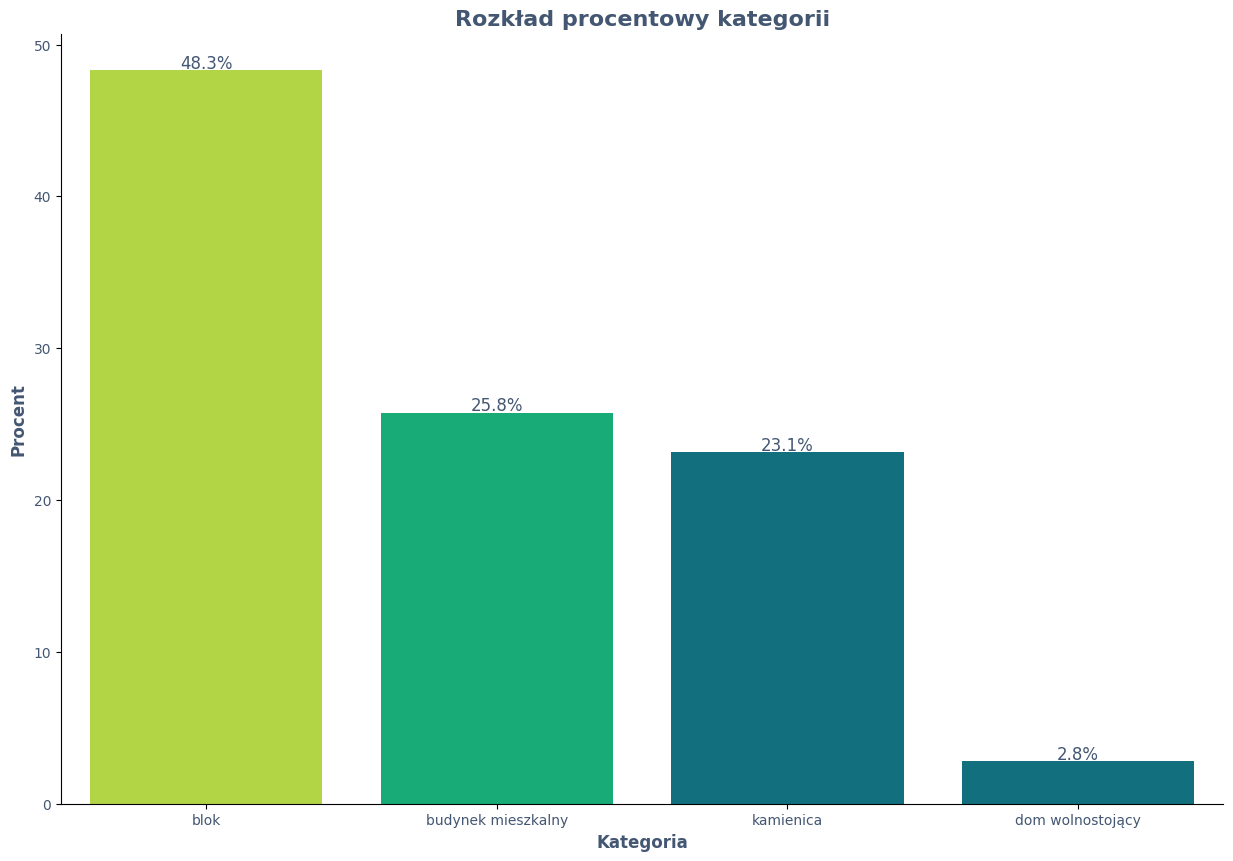

In [22]:
def display_category_proportions(data: pd.Series, title: str):

    # Calculate the percentage of each category
    category_percentage = data.value_counts(normalize=True) * 100

    # Create a bar plot
    fig, ax = plt.subplots(figsize=aesthetics_plots["figsize"]["multiplot"])
    my_palette = ['#bfed2d'] + ['#00c37f'] + ["#007e90"] + ['#51006f']*2

    unique_categories = data.unique()
    length = len(unique_categories)
    if (length - 5) <= 0:
        adjusted_length = 1
    else:
        adjusted_length = length - 5
    my_palette = ['#bfed2d'] + ['#00c37f'] + ["#007e90"]*2 + ['#51006f']*adjusted_length

    # Make the index more readable
    more_readable_index = []
    for _index in category_percentage.index:
        more_readable_index.append(_index.replace('_', ' '))
    category_percentage.index = more_readable_index

    sns.barplot(x=category_percentage.index, y=category_percentage.values, ax=ax, palette=my_palette)
    
    # Add labels to the plot
    plt.title(title, color=aesthetics_plots['label_color'], fontsize=aesthetics_plots['title_size'], weight=aesthetics_plots['fontweight'])
    plt.xlabel('Kategoria', color=aesthetics_plots['label_color'], fontsize=aesthetics_plots['y_and_x_label_size'], weight=aesthetics_plots['fontweight'])
    plt.ylabel('Procent', color=aesthetics_plots['label_color'], fontsize=aesthetics_plots['y_and_x_label_size'], weight=aesthetics_plots['fontweight'])

    plt.xticks(color=aesthetics_plots['label_color'])
    plt.yticks(color=aesthetics_plots['label_color'])
    
    sns.despine(right=True, top=True)


    # Add percentage labels on the bars
    for p in ax.patches:
        ax.annotate(f"{p.get_height():.1f}%", (p.get_x() + p.get_width() / 2., p.get_height()),
                    ha='center', va='center', fontsize=12, color=aesthetics_plots['label_color'], xytext=(0, 5),
                    textcoords='offset points')

    # Display the plot
    plt.show()


display_category_proportions(combined_df[('rodzaj_i_rocznik', 'typ_budynku')], "Rozkład procentowy kategorii")

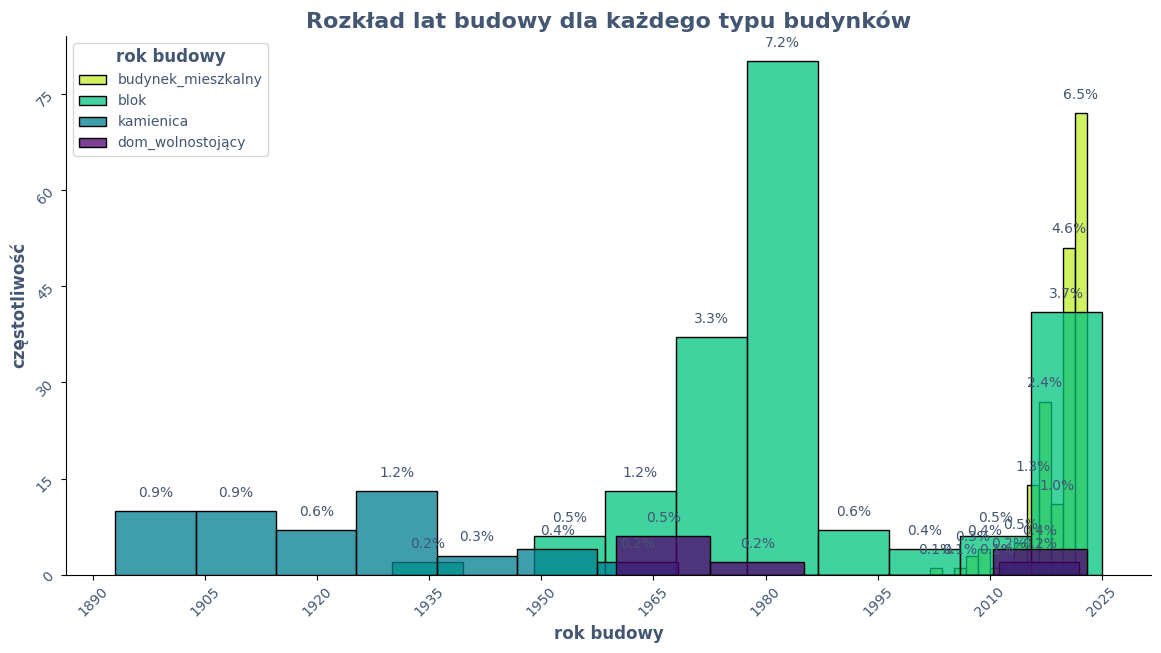

In [23]:
show_categorical_data_percentage_distribution(
    combined_df,  
    ('rodzaj_i_rocznik', 'typ_budynku'),
    ('rodzaj_i_rocznik', 'rok_budowy'),
    'Rozkład lat budowy dla każdego typu budynków'
    )

**Wnioski dotyczące typu budynku i roku budowy**:

1. **Blok mieszkalne**:<br>
obejmujący `48,2%` zbioru danych, jest dominującą kategorią, wskazującą na silną preferencję dla ofert mieszkaniowych. Wybór ten jest powszechny zarówno w "historycznych obszarach miejskich", jak i w późniejszej erze, często charakteryzującej się "budownictwem wielkopłytowym" z czasów komunizmu, a także w nowszych inwestycjach, pokazując stałą podaż na tego typu mieszkania w różnych epokach.

1. **Trendy w urbanistyce**:<br>
Znaczący wzrost budownictwa po roku `2000` wskazuje na wzrost dostępności nowszych rezydencji. Jednak `"domy szeregowe"` i `"domy wolnostojące"` stanowią odpowiednio tylko `0,3%` i `2,8%` typów mieszkań. Ten niedobór sugeruje trend rozwoju urbanistycznego, który faworyzuje budynki wielopiętrowe zamiast pojedynczych domów, wskazując na preferencję dla ekspansji pionowej w zabudowie mieszkaniowej.


In [24]:
def move_index_to_last(series, index_to_move):
    """
    Moves a specified index to the last position in a pandas Series.

    Args:
    series (pd.Series): The original series.
    index_to_move (str): The index to be moved to the last position.

    Returns:
    pd.Series: A new series with the specified index moved to the last position.
    """
    if index_to_move not in series.index:
        raise ValueError(f"Index '{index_to_move}' not found in the Series.")

    # Extracting the indices
    idx_list = series.index.tolist()

    # Remove the index to move and then append it at the end
    idx_list.remove(index_to_move)
    idx_list.append(index_to_move)

    # Reindexing the series
    return series.reindex(idx_list)

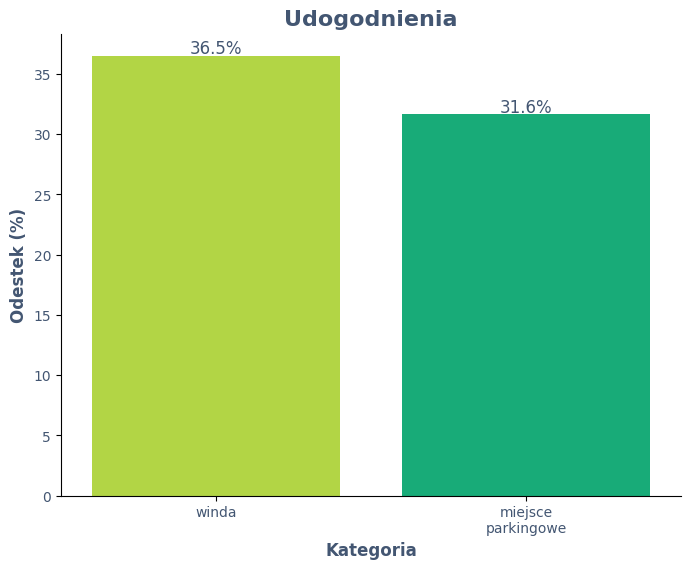

In [30]:
def visualize_true_percentage_by_category(df: pd.DataFrame, main_category: str):
    # Check if the DataFrame contains the main category
    if main_category not in df.columns.get_level_values(0):
        raise KeyError(f"Main category '{main_category}' not found in DataFrame.")

    # Extract subcategories for the given main category
    subcategories = [col for col in df.columns if col[0] == main_category]

    # Calculate percentage of True values for each subcategory
    percentages = {}
    for subcat in subcategories:
        percentages[subcat[1]] = (df[subcat].sum() / len(df)) * 100

    # Convert to Series for plotting
    category_percentage = pd.Series(percentages)

    # Sort by percentage, 'no_information' should be last
    category_percentage = category_percentage.sort_values(ascending=False)
    if 'no_information' in category_percentage.index:
        category_percentage = move_index_to_last(category_percentage, 'brak_informacji')

    # Create a bar plot
    if category_percentage.index.__len__() >= 5:
        plot_size = aesthetics_plots["figsize"]["multiplot"]
    else:
        plot_size = aesthetics_plots["figsize"]["singleplot"]

    fig, ax = plt.subplots(figsize=plot_size)

    # Set the palette
    length = len(category_percentage.index)
    if (length - 5) <= 0:
        adjusted_length = 1
    else:
        adjusted_length = length - 5
    my_palette = ['#bfed2d'] + ['#00c37f'] + ["#007e90"]*2 + ['#51006f']*adjusted_length

    if 'brak_informacji' in category_percentage.index:
        my_palette = my_palette[:max(1, length - 1)] + ['#b3b3b3']

    more_readable_index = []
    for _index in category_percentage.index:
        more_readable_index.append(_index.replace('_', '\n'))

    category_percentage.index = more_readable_index

    sns.barplot(x=category_percentage.index, y=category_percentage.values, ax=ax, palette=my_palette)
    
    # Add labels to the plot
    title = main_category.replace('_', ' ').title()
    plt.title(title, color=aesthetics_plots['label_color'], fontsize=aesthetics_plots['title_size'], weight=aesthetics_plots['fontweight'])
    plt.xlabel('Kategoria', color=aesthetics_plots['label_color'], fontsize=aesthetics_plots['y_and_x_label_size'], weight=aesthetics_plots['fontweight'])
    plt.ylabel('Odestek (%)', color=aesthetics_plots['label_color'], fontsize=aesthetics_plots['y_and_x_label_size'], weight=aesthetics_plots['fontweight'])

    plt.xticks(color=aesthetics_plots['label_color'])
    plt.yticks(color=aesthetics_plots['label_color'])
    
    sns.despine(right=True, top=True)

    # Add percentage labels on the bars
    for p in ax.patches:
        ax.annotate(f"{p.get_height():.1f}%", (p.get_x() + p.get_width() / 2., p.get_height()),
                    ha='center', va='center', fontsize=12, color=aesthetics_plots['label_color'], xytext=(0, 5),
                    textcoords='offset points')

    # Display the plot
    plt.show()

visualize_true_percentage_by_category(combined_df, 'udogodnienia')

**Wnioski udogodnienia**:
1. **Windy**:<br>
są uwzględnione w `36,5%` ofert apartamentów.
1. **Miejsca parkingowe**:<br>
są dostępne w `31,6%` ofert.

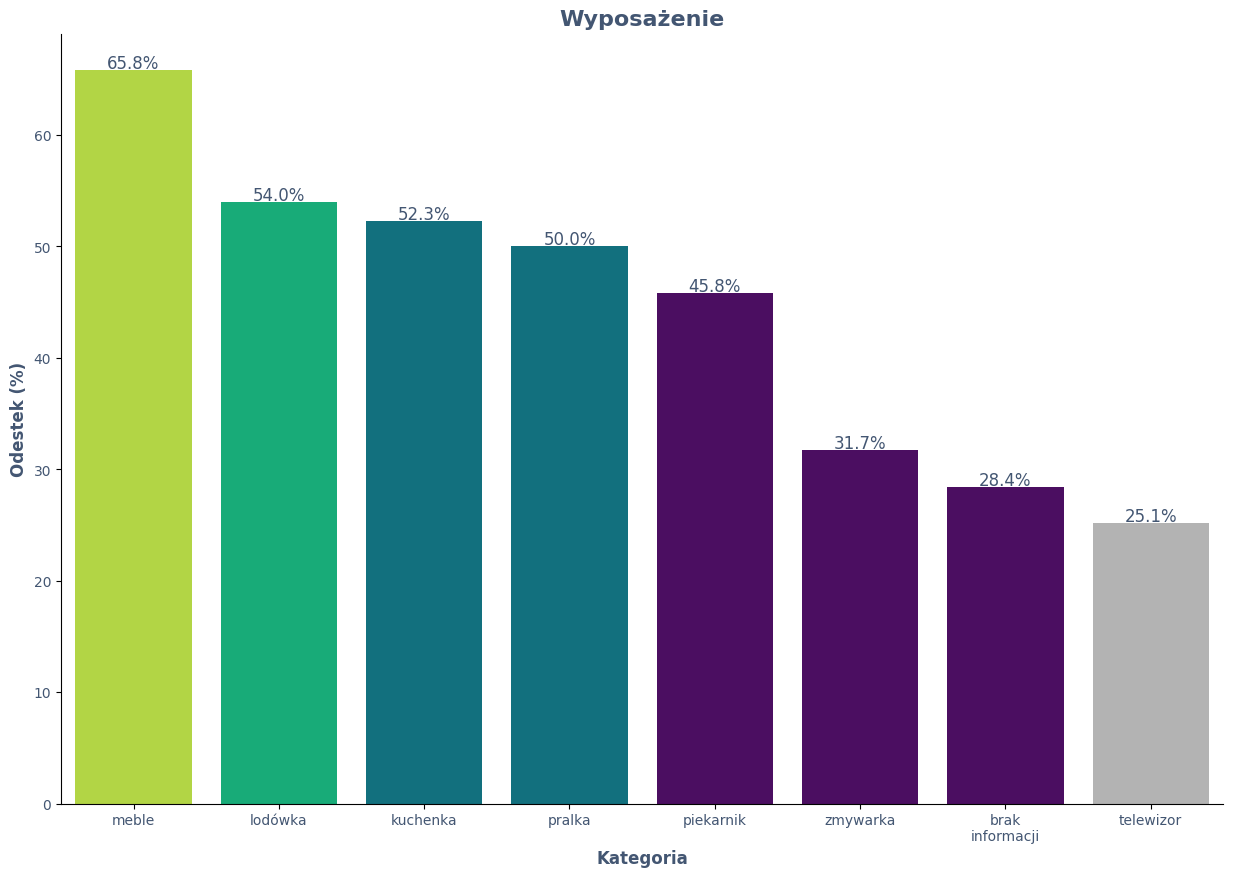

In [31]:
visualize_true_percentage_by_category(combined_df, 'wyposażenie')

**Wnioski wyposażenie**:

1. **Trendy w wyposażeniu mieszkań**:<br>
Meble znajdują się w `65,8%` mieszkań, podczas gdy `lodówki` i `kuchenki` są obecne odpowiednio w `54%` i `52,3%` ofert, a `pralki` znajdują się dokładnie w `połowie` ofert. Wskazuje to na skłonność do wyposażania mieszkań w niezbędne urządzenia dla najemców poszukujących nieruchomości gotowych do zamieszkania.
1. **Rzadsze udogodnienia**:<br>
Obecność `telewizorów` w `25,1%` i `zmywarek` w `31,7%` ofert pokazuje, że są one mniej powszechne, prawdopodobnie i są uważane za nieistotne.

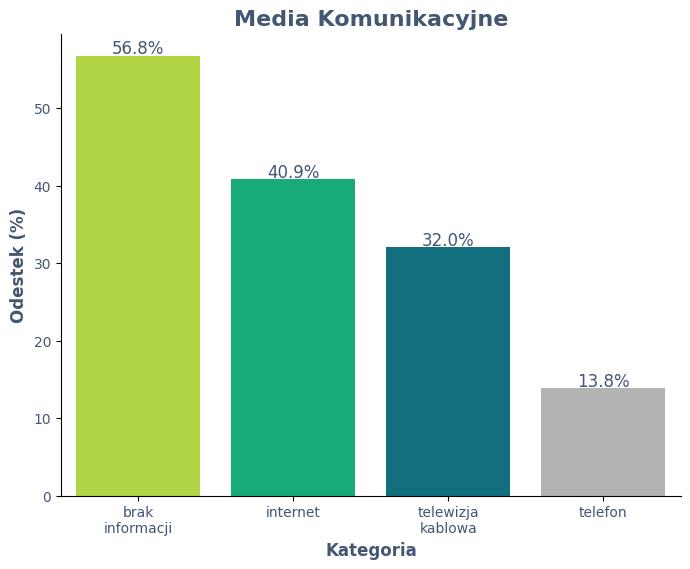

In [32]:
visualize_true_percentage_by_category(combined_df, 'media_komunikacyjne')

**Wnioski usługi multimedialne**:
1. **Powszechność**:<br>
`Dostęp do Internetu` jest wymieniony w `40,9%` ofert i `32,0%` dla `telewizji kablowej`.
1. **Brak informacji**:<br>
`Brak informacji` o typach mediów jest zgłaszany w `56,8%` ofert, co pokazuje, że dla większości są to nieistotne informacje.

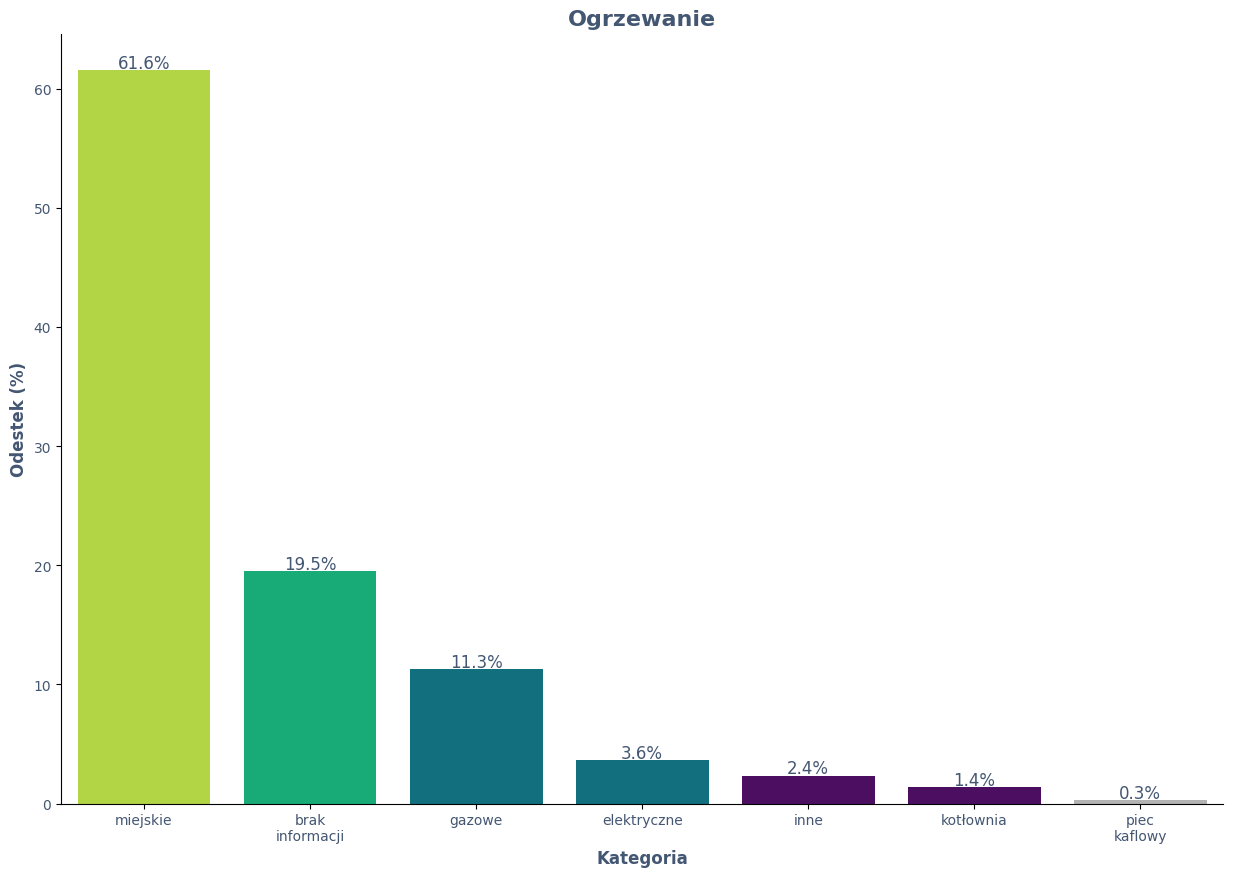

In [33]:
visualize_true_percentage_by_category(combined_df, 'ogrzewanie')

**Wnioski dotyczące ogrzewania**:

1. **Ogrzewanie miejskie**:<br>
jest najczęściej zgłaszanym typem (`61,6%`).
1. **Inne ogrzewanie**:<br>
Ogrzewanie gazowe (`11,3%`), a zwłaszcza `elektryczne` (`3,6%`) jest mało spotykane głównie ze względu na wysokie koszty.


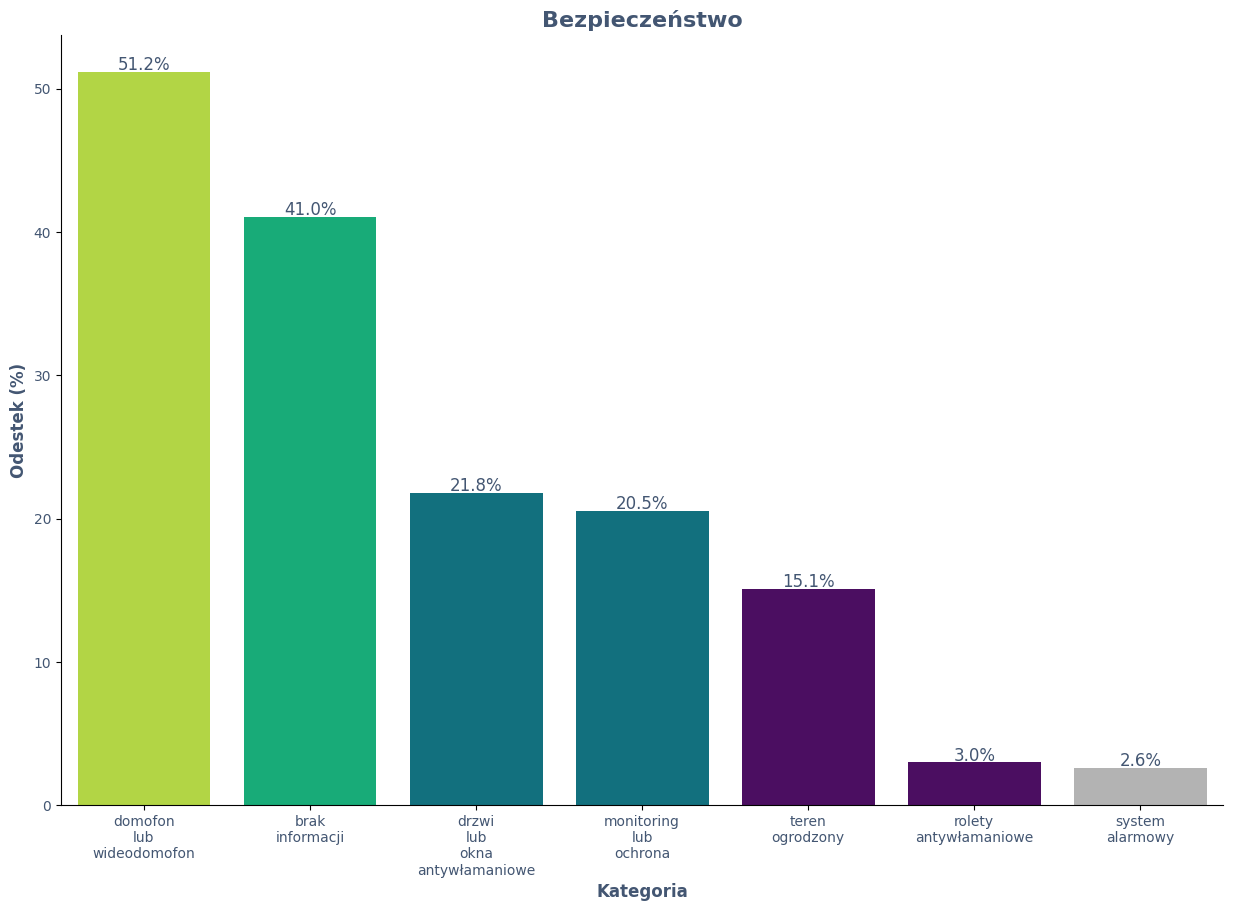

In [35]:
visualize_true_percentage_by_category(combined_df, 'bezpieczeństwo')

**Wnioski dotyczące zabezpieczeń**:

1. **Systemy Domofonowe:**:<br>
`Systemy domofonowe` lub `wideodomofonowe` są wymienione w `51,2%` ofert, co świadczy o ich powszechnym występowaniu.
1. **Zaawansowanych Zabezpieczeń**:<br>
Bardziej zaawansowane funkcje bezpieczeństwa, takie jak `systemy alarmowe`, są wspomniane tylko w `2,6%` ofert, a rolety antywłamaniowe w `3,0%`, co sugeruje, że mogą być one rzadziej spotykane lub wyróżniane wyłącznie w ofertach premium.

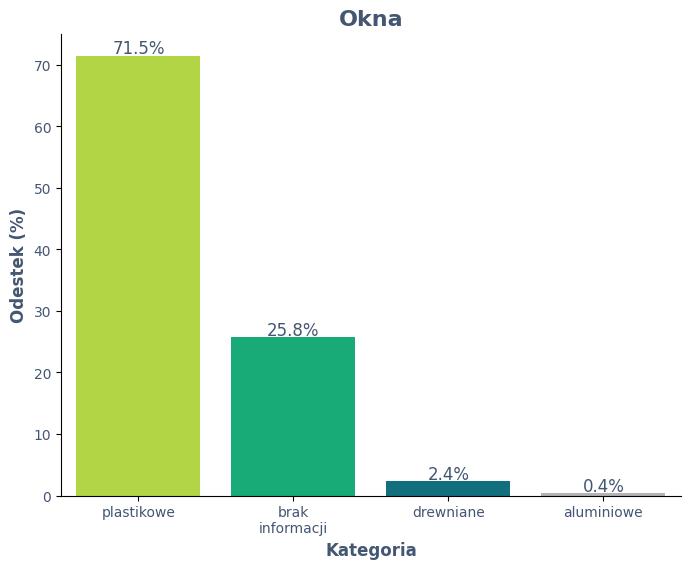

In [36]:
visualize_true_percentage_by_category(combined_df, 'okna')

**Wnioski okna**:

1. **Plastik**:<br>
Okna `plastikowe` dominują w cechach na poziomie `71,5%`.
1. **Brak informacji**:<br>
Zauważalny jest "brak informacji" w `25,8%` ofert dotyczących typów okien.

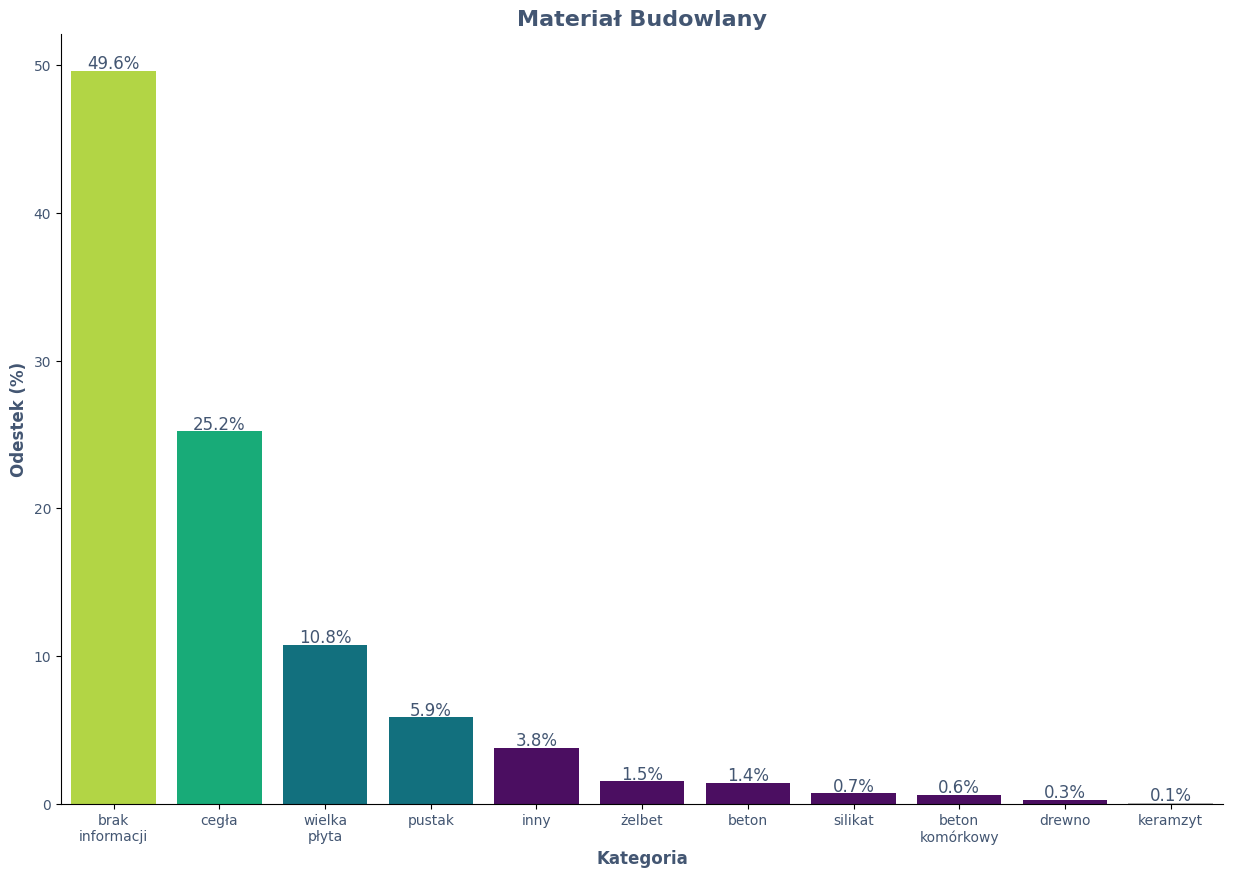

In [37]:
visualize_true_percentage_by_category(combined_df, 'materiał_budowlany')

**Wnioski materiał budowlany**:

1. **Cegła**:<br>
jest określona w `25,2%` nieruchomości.
1. **Wielka płyta**:<br>
jest wymieniany w `10,8%`, ale wynik może być mniejszy przez niewymienienie go ze względu na niepopularność wśród potencjalnych najemców.
1. **Brak informacji**:<br>
Prawie połowa ofert, `49,6%`, nie ujawnia materiału budowlanego.

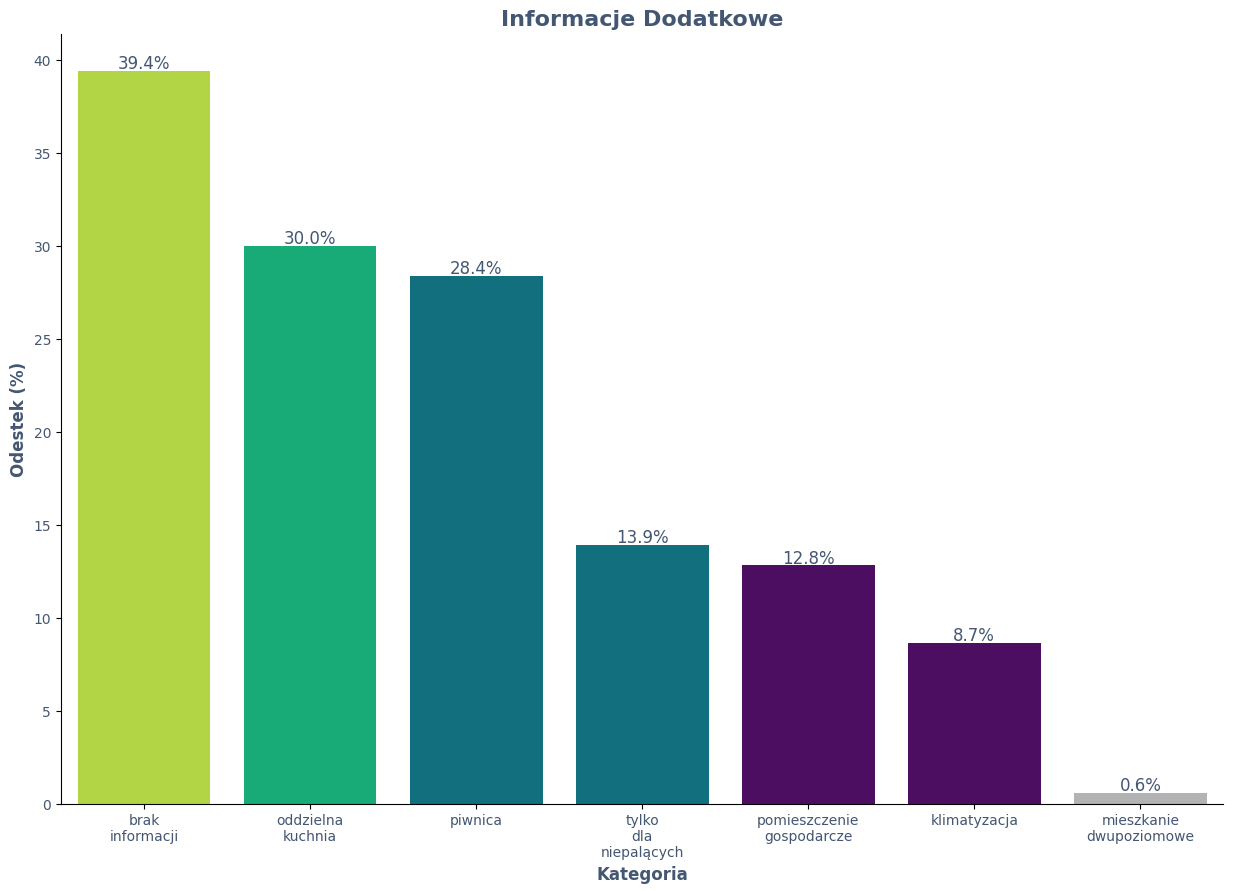

In [38]:
visualize_true_percentage_by_category(combined_df, 'informacje_dodatkowe')

**Wnioski dodatkowe informacje**:
1. **Częste**:<br>
`Oddzielna kuchnia` i `piwnica` to odpowiednio `30,0%` i `28,4%` ofert.

1. **Rzadkie**:<br>
Mniejszy, ale znaczący odsetek ofert określa `tylko dla niepalących` (13,9%) oraz `pomieszczenie gospodarcze` (12,8%).

1. **Bardzo rzadkie**:<br>
`Klimatyzacja` i `duplex` są rzadkie, odpowiednio `8,7%` i `0,6%`, co może sugerować, że te cechy są niestandardowe. Przeważająca liczba ofert `(39,4%) `nie dostarcza żadnych dodatkowych informacji`.
